B12 Deficiency Prediction Model - Stage 1 Random Forest
*** FIXED DATA LEAKAGE VERSION ***
Key Improvements:
- Excluded B12_mol to prevent target leakage
- Feature selection performed ONLY on training data
- Larger test set (25% instead of 15%)
- Focus on methylation features over clinical biomarkers
Clinical data: /Users/heweilin/Desktop/P056/7Clinical_data50.csv
DMR data: /Users/heweilin/Desktop/P056/4DNA_DMRs.csv
Methylation data: /Users/heweilin/Desktop/P056_Code_2/Processed_Data/1_PD_PromoterRegion_CpGs.csv
Output directory: /Users/heweilin/Desktop/P056_Code_3/Data
2025-08-23 18:33:49,977 - INFO - Logging setup completed
B12 DEFICIENCY PREDICTION MODEL - STAGE 1 RANDOM FOREST
*** FIXED DATA LEAKAGE VERSION ***
Timestamp: 20250823_183349
Output directory: /Users/heweilin/Desktop/P056_Code_3/Data
File prefix: RF_Stage1_NoLeakage_

Key Improvements:
- Removed B12_mol to avoid target leakage
- Feature selection ONLY on training data
- Larger test set (25% instead of 15%)
- Focus on om

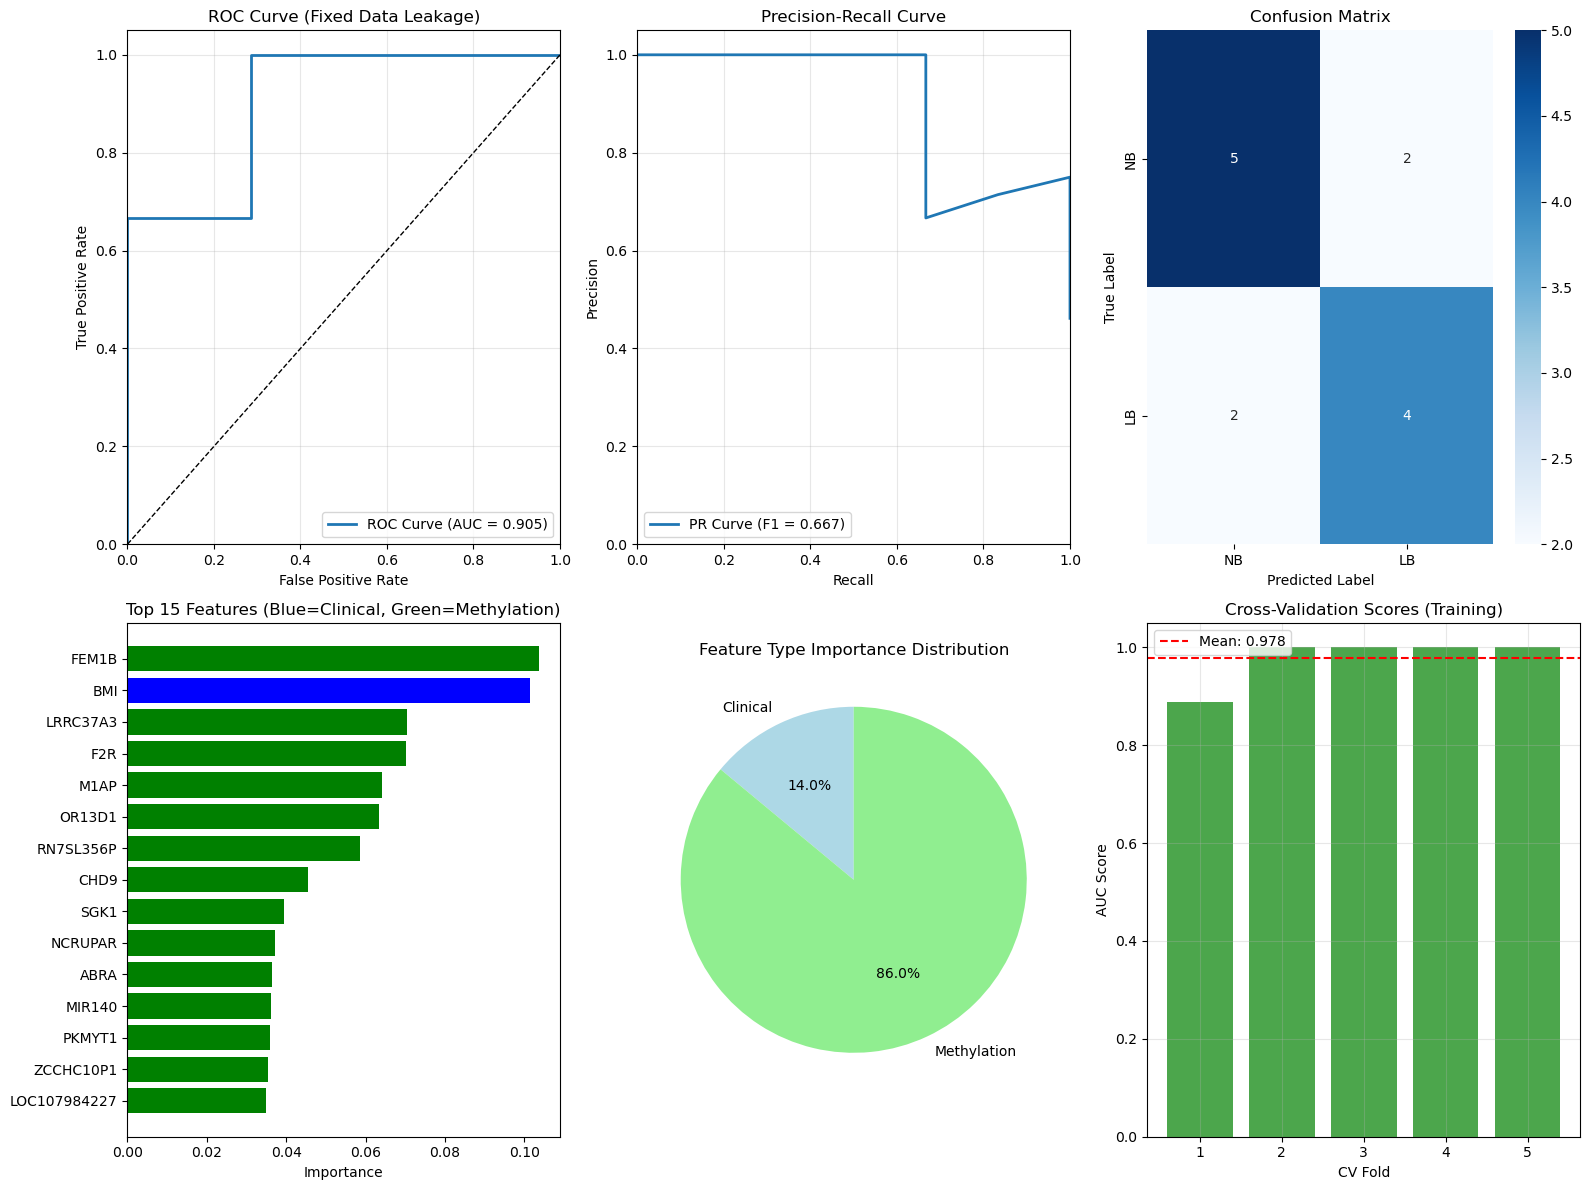


STEP 8: SAVING MODEL
    Trained model saved to: /Users/heweilin/Desktop/P056_Code_3/Data/RF_Stage1_NoLeakage_trained_model_20250823_183349.joblib
    Label encoder saved to: /Users/heweilin/Desktop/P056_Code_3/Data/RF_Stage1_NoLeakage_label_encoder_20250823_183349.joblib
    Feature names saved to: /Users/heweilin/Desktop/P056_Code_3/Data/RF_Stage1_NoLeakage_feature_names_20250823_183349.json
    Processed data saved to: /Users/heweilin/Desktop/P056_Code_3/Data/RF_Stage1_NoLeakage_processed_data_20250823_183349.joblib

PIPELINE COMPLETION SUMMARY - NO DATA LEAKAGE
Start time: 2025-08-23 18:33:49
End time: 2025-08-23 18:34:36
Total duration: 0:00:46.370250

KEY MODEL PERFORMANCE METRICS
1. AUC (Area Under ROC Curve):     0.9048
   └─ Model's ability to distinguish between B12 deficient and normal
2. Accuracy (Overall Correctness):  0.6923
   └─ Proportion of correct predictions (both LB and NB)
3. Precision (Positive Predictive): 0.6667
   └─ Among predicted deficient, how many are tr

In [25]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
B12 Deficiency Prediction Model - Stage 1 Random Forest Model
Predicting B12 status based on clinical features and DNA methylation features

Author: Research Team
Date: August 23, 2025
Version: 1.0 - Fixed Data Leakage Issues

Feature Set: Clinical features (excluding B12_mol) + DNA methylation promoter region CpG sites
Objective: Predict B12 deficiency status (LB vs NB) without data leakage
"""

import os
import sys
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (train_test_split, StratifiedKFold, 
                                   cross_val_score, GridSearchCV)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import (SelectKBest, f_classif, RFE, 
                                     VarianceThreshold, SelectFromModel)
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, precision_recall_curve,
                           f1_score, accuracy_score, matthews_corrcoef,
                           cohen_kappa_score, brier_score_loss)

# Statistical tests
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_ind

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# Set font for plots
rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
rcParams['axes.unicode_minus'] = False

# Other utilities
import joblib
import json
from datetime import datetime
import logging

class B12PredictionRF:
    """B12 deficiency prediction Random Forest model class - Fixed Data Leakage"""
    
    def __init__(self, output_dir="/Users/heweilin/Desktop/P056_Code_3/Data", prefix="RF_"):
        """
        Initialize the model class
        
        Parameters:
        -----------
        output_dir : str
            Directory to save output files
        prefix : str
            Prefix for output files
        """
        self.output_dir = output_dir
        self.prefix = prefix
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
        
        # Setup logging
        self.setup_logging()
        
        # Initialize data storage
        self.clinical_data = None
        self.methylation_data = None
        self.dmr_data = None
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.X_val = None
        self.y_train = None
        self.y_test = None
        self.y_val = None
        self.feature_names = None
        self.model = None
        self.scaler = None
        self.label_encoder = None
        
        # Store raw data for proper train/test splitting
        self.raw_clinical_features = None
        self.raw_methylation_data = None
        
        print("="*80)
        print("B12 DEFICIENCY PREDICTION MODEL - STAGE 1 RANDOM FOREST")
        print("*** FIXED DATA LEAKAGE VERSION ***")
        print("="*80)
        print(f"Timestamp: {self.timestamp}")
        print(f"Output directory: {output_dir}")
        print(f"File prefix: {prefix}")
        print("\nKey Improvements:")
        print("- Removed B12_mol to avoid target leakage")
        print("- Feature selection ONLY on training data")
        print("- Larger test set (25% instead of 15%)")
        print("- Focus on omics features over clinical biomarkers")
        print("="*80)
    
    def setup_logging(self):
        """Setup logging configuration"""
        log_file = os.path.join(self.output_dir, f"{self.prefix}model_log_{self.timestamp}.txt")
        
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler(log_file),
                logging.StreamHandler(sys.stdout)
            ]
        )
        self.logger = logging.getLogger(__name__)
        self.logger.info("Logging setup completed")
    
    def load_data(self, clinical_path, dmr_path, methylation_path):
        """
        Load and preprocess data files
        
        Parameters:
        -----------
        clinical_path : str
            Path to clinical data CSV file
        dmr_path : str
            Path to DMR data CSV file
        methylation_path : str
            Path to methylation data CSV file
        """
        print("\n" + "="*50)
        print("STEP 1: DATA LOADING AND PREPROCESSING")
        print("="*50)
        
        self.logger.info("Starting data loading process")
        
        # Load clinical data
        print(f"\n1.1 Loading clinical data from: {clinical_path}")
        try:
            self.clinical_data = pd.read_csv(clinical_path)
            print(f"    Clinical data shape: {self.clinical_data.shape}")
            print(f"    Columns: {list(self.clinical_data.columns)}")
            self.logger.info(f"Clinical data loaded successfully: {self.clinical_data.shape}")
        except Exception as e:
            print(f"    Error loading clinical data: {e}")
            self.logger.error(f"Error loading clinical data: {e}")
            return False
        
        # Load DMR data
        print(f"\n1.2 Loading DMR data from: {dmr_path}")
        try:
            self.dmr_data = pd.read_csv(dmr_path, low_memory=False)
            print(f"    DMR data shape: {self.dmr_data.shape}")
            print(f"    Columns: {list(self.dmr_data.columns[:10])}...") # Show first 10 columns
            self.logger.info(f"DMR data loaded successfully: {self.dmr_data.shape}")
        except Exception as e:
            print(f"    Error loading DMR data: {e}")
            self.logger.error(f"Error loading DMR data: {e}")
            return False
        
        # Load methylation data
        print(f"\n1.3 Loading methylation data from: {methylation_path}")
        try:
            self.methylation_data = pd.read_csv(methylation_path)
            print(f"    Methylation data shape: {self.methylation_data.shape}")
            print(f"    Gene symbols: {self.methylation_data.shape[0]} genes")
            print(f"    Samples: {self.methylation_data.shape[1]-1} samples") # -1 for Gene_Symbol column
            self.logger.info(f"Methylation data loaded successfully: {self.methylation_data.shape}")
        except Exception as e:
            print(f"    Error loading methylation data: {e}")
            self.logger.error(f"Error loading methylation data: {e}")
            return False
        
        return True
    
    def preprocess_clinical_data(self):
        """Preprocess clinical data and extract relevant features - EXCLUDING B12_mol"""
        print("\n1.4 Preprocessing clinical data (EXCLUDING B12_mol to avoid target leakage)")
        
        # Check B12 status distribution
        print("    B12 status distribution:")
        b12_counts = self.clinical_data['B12_status'].value_counts()
        print(f"    {b12_counts}")
        
        # Select relevant clinical features - EXCLUDING B12_mol and ethnicity to avoid data leakage and categorical issues
        clinical_features = ['age', 'BMI', 'parity', 'B12supplem', 
                           'v1p_MultivitTab', 'v1p_FolicAcid', 'smoking']
        
        # Note: B12_mol is EXCLUDED as it directly defines the target variable
        # Note: ethnicity is EXCLUDED to avoid categorical encoding issues
        print("    *** IMPORTANT: B12_mol EXCLUDED to prevent target leakage ***")
        print("    *** IMPORTANT: ethnicity EXCLUDED to avoid categorical encoding issues ***")
        
        # Check which features are available
        available_features = []
        for feature in clinical_features:
            if feature in self.clinical_data.columns:
                available_features.append(feature)
            else:
                print(f"    Warning: {feature} not found in clinical data")
        
        print(f"    Available clinical features: {available_features}")
        
        # Extract clinical features
        clinical_X = self.clinical_data[available_features].copy()
        
        # Handle missing values
        print("    Handling missing values in clinical data:")
        missing_counts = clinical_X.isnull().sum()
        print(f"    Missing values per feature:")
        for feature, count in missing_counts.items():
            if count > 0:
                print(f"      {feature}: {count} missing values")
        
        # Fill missing values with median for all features (all should be numerical now)
        for col in clinical_X.columns:
            if clinical_X[col].isnull().sum() > 0:
                median_val = clinical_X[col].median()
                clinical_X[col].fillna(median_val, inplace=True)
                print(f"      Filled {col} with median: {median_val}")
        
        # Ensure all features are numerical
        print("    Converting all features to numerical format:")
        for col in clinical_X.columns:
            clinical_X[col] = pd.to_numeric(clinical_X[col], errors='coerce')
            print(f"      {col}: {clinical_X[col].dtype}")
        
        # Handle any remaining NaN values from conversion
        if clinical_X.isnull().sum().sum() > 0:
            print("    Handling any NaN values from conversion:")
            clinical_X = clinical_X.fillna(clinical_X.median())
        
        print(f"    Final clinical data shape: {clinical_X.shape}")
        print(f"    All features are numerical: {all(clinical_X.dtypes.apply(lambda x: np.issubdtype(x, np.number)))}")
        
        return clinical_X, available_features
    
    def prepare_methylation_data(self):
        """Prepare methylation data for train/test splitting"""
        print("\n1.5 Preparing methylation data")
        
        # Prepare methylation data (transpose to have samples as rows)
        methylation_df = self.methylation_data.set_index('Gene_Symbol').T
        print(f"    Methylation data after transpose: {methylation_df.shape}")
        
        # Handle missing values in methylation data
        missing_counts = methylation_df.isnull().sum().sum()
        if missing_counts > 0:
            print(f"    Found {missing_counts} missing values in methylation data")
            # Fill with median values
            methylation_df = methylation_df.fillna(methylation_df.median())
            print("    Missing values filled with median")
        
        # Get sample IDs that match clinical data
        clinical_ids = self.clinical_data['DNA_ID'].values
        methylation_samples = methylation_df.index.values
        
        print(f"    Clinical DNA IDs: {len(clinical_ids)}")
        print(f"    Methylation samples: {len(methylation_samples)}")
        
        # Find common samples
        common_samples = list(set(clinical_ids) & set(methylation_samples))
        print(f"    Common samples: {len(common_samples)}")
        
        if len(common_samples) == 0:
            print("    Warning: No common samples found between clinical and methylation data")
            return None
        
        # Filter methylation data to common samples
        methylation_filtered = methylation_df.loc[common_samples]
        print(f"    Filtered methylation data: {methylation_filtered.shape}")
        
        return methylation_filtered, common_samples
    
    def prepare_initial_dataset(self):
        """Prepare initial dataset before train/test split"""
        print("\n1.6 Combining initial features")
        
        # Get clinical features
        clinical_X, clinical_features = self.preprocess_clinical_data()
        
        # Get methylation features
        methylation_result = self.prepare_methylation_data()
        if methylation_result is None:
            print("    Using only clinical features")
            self.X = clinical_X
            self.feature_names = clinical_features
            self.y = self.clinical_data['B12_status'].values
            self.raw_methylation_data = None
        else:
            methylation_X, common_samples = methylation_result
            print("    Combining clinical and methylation features")
            
            # Align samples between clinical and methylation data
            clinical_filtered = self.clinical_data[self.clinical_data['DNA_ID'].isin(common_samples)]
            clinical_filtered = clinical_filtered.set_index('DNA_ID').loc[common_samples]
            clinical_X_filtered = clinical_filtered[clinical_features]
            
            # Align methylation data
            methylation_X_aligned = methylation_X.loc[common_samples]
            
            # Combine features
            self.X = pd.concat([clinical_X_filtered, methylation_X_aligned], axis=1)
            self.feature_names = clinical_features + list(methylation_X_aligned.columns)
            
            # Store raw methylation data for later feature selection
            self.raw_methylation_data = methylation_X_aligned
            self.raw_clinical_features = clinical_X_filtered
            
            # Update target variable for aligned samples
            self.y = clinical_filtered['B12_status'].values
        
        print(f"    Initial combined data shape: {self.X.shape}")
        print(f"    Total initial features: {len(self.feature_names)}")
        
        # Encode target variable
        self.label_encoder = LabelEncoder()
        self.y = self.label_encoder.fit_transform(self.y)
        print(f"    Target encoding: {dict(zip(self.label_encoder.classes_, self.label_encoder.transform(self.label_encoder.classes_)))}")
        
        return True
    
    def split_data(self, test_size=0.25, val_size=0.15, random_state=42):
        """Split data into train, validation, and test sets - LARGER TEST SET"""
        print("\n" + "="*50)
        print("STEP 2: DATA SPLITTING (25% TEST SET)")
        print("="*50)
        
        print(f"Total samples: {len(self.X)}")
        print(f"Test size: {test_size} ({int(len(self.X) * test_size)} samples)")
        print(f"Validation size: {val_size} ({int(len(self.X) * val_size)} samples)")
        print(f"Training size: {1 - test_size - val_size} ({int(len(self.X) * (1 - test_size - val_size))} samples)")
        
        # First split: separate test set (larger test set to ensure robust evaluation)
        X_temp, self.X_test, y_temp, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state, 
            stratify=self.y
        )
        
        # Second split: separate training and validation
        val_size_adjusted = val_size / (1 - test_size)  # Adjust validation size
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            X_temp, y_temp, test_size=val_size_adjusted, random_state=random_state, 
            stratify=y_temp
        )
        
        print(f"\nFinal data splits:")
        print(f"    Training set: {self.X_train.shape[0]} samples")
        print(f"    Validation set: {self.X_val.shape[0]} samples") 
        print(f"    Test set: {self.X_test.shape[0]} samples")
        
        # Print class distribution in each set
        print(f"\nClass distribution:")
        train_dist = pd.Series(self.y_train).value_counts()
        val_dist = pd.Series(self.y_val).value_counts()
        test_dist = pd.Series(self.y_test).value_counts()
        
        print(f"    Training - LB: {train_dist.get(1, 0)}, NB: {train_dist.get(0, 0)}")
        print(f"    Validation - LB: {val_dist.get(1, 0)}, NB: {val_dist.get(0, 0)}")
        print(f"    Test - LB: {test_dist.get(1, 0)}, NB: {test_dist.get(0, 0)}")
        
        return True
    
    def perform_feature_selection_on_training_data(self):
        """
        Perform feature selection ONLY on training data to prevent data leakage
        """
        print("\n" + "="*50)
        print("STEP 3: FEATURE SELECTION ON TRAINING DATA ONLY")
        print("="*50)
        
        print("*** CRITICAL: Feature selection performed ONLY on training data ***")
        print("*** This prevents data leakage and ensures valid model evaluation ***")
        
        initial_features = self.X_train.shape[1]
        print(f"Initial number of features: {initial_features}")
        
        # Separate clinical and methylation features in training data
        if self.raw_clinical_features is not None:
            n_clinical = self.raw_clinical_features.shape[1]
            clinical_feature_names = self.feature_names[:n_clinical]
            methylation_feature_names = self.feature_names[n_clinical:]
            
            X_train_clinical = self.X_train.iloc[:, :n_clinical]
            X_train_methylation = self.X_train.iloc[:, n_clinical:]
            
            print(f"    Clinical features in training: {n_clinical}")
            print(f"    Methylation features in training: {len(methylation_feature_names)}")
        else:
            # Only clinical features
            clinical_feature_names = self.feature_names
            methylation_feature_names = []
            X_train_clinical = self.X_train
            X_train_methylation = pd.DataFrame()
        
        # 3.1 Statistical feature selection for methylation features (TRAINING DATA ONLY)
        selected_methylation_features = []
        if len(methylation_feature_names) > 0:
            print("\n3.1 Methylation feature selection on training data")
            
            # Perform t-test for each methylation feature using ONLY training data
            pvalues = []
            effect_sizes = []
            gene_names = []
            
            for i, gene in enumerate(methylation_feature_names):
                values = X_train_methylation.iloc[:, i].values
                
                # Skip if all values are the same or contain NaN
                if len(np.unique(values)) == 1 or np.any(np.isnan(values)):
                    continue
                
                # Split by B12 status (TRAINING DATA ONLY)
                lb_values = values[self.y_train == 1]  # LB group
                nb_values = values[self.y_train == 0]  # NB group
                
                if len(lb_values) == 0 or len(nb_values) == 0:
                    continue
                
                # Perform t-test
                try:
                    statistic, pvalue = ttest_ind(lb_values, nb_values)
                    
                    # Calculate Cohen's d (effect size)
                    pooled_std = np.sqrt(((len(lb_values) - 1) * np.var(lb_values, ddof=1) + 
                                        (len(nb_values) - 1) * np.var(nb_values, ddof=1)) / 
                                       (len(lb_values) + len(nb_values) - 2))
                    
                    if pooled_std > 0:  # Avoid division by zero
                        cohens_d = abs(np.mean(lb_values) - np.mean(nb_values)) / pooled_std
                    else:
                        cohens_d = 0
                    
                    pvalues.append(pvalue)
                    effect_sizes.append(cohens_d)
                    gene_names.append(gene)
                    
                except Exception as e:
                    continue
            
            # Create results dataframe
            if len(gene_names) > 0:
                results_df = pd.DataFrame({
                    'Gene': gene_names,
                    'p_value': pvalues,
                    'effect_size': effect_sizes
                })
                
                print(f"    Total methylation genes tested: {len(results_df)}")
                print(f"    Significant genes (p < 0.05): {sum(results_df['p_value'] < 0.05)}")
                print(f"    Genes with large effect size (Cohen's d > 0.3): {sum(results_df['effect_size'] > 0.3)}")
                
                # Select features based on p-value and effect size
                significant_genes = results_df[
                    (results_df['p_value'] < 0.05) & (results_df['effect_size'] > 0.3)
                ]['Gene'].tolist()
                
                # If too few features, relax criteria
                if len(significant_genes) < 5:
                    print("    Too few features, relaxing criteria to p < 0.1")
                    significant_genes = results_df[
                        (results_df['p_value'] < 0.1) & (results_df['effect_size'] > 0.2)
                    ]['Gene'].tolist()
                
                # If still too few, take top 10 by effect size
                if len(significant_genes) < 5:
                    print("    Still too few features, taking top 10 by effect size")
                    significant_genes = results_df.nlargest(10, 'effect_size')['Gene'].tolist()
                
                # If too many features, select top ones
                if len(significant_genes) > 20:
                    print("    Too many features, keeping top 20 by effect size")
                    top_genes = results_df.nlargest(20, 'effect_size')['Gene'].tolist()
                    significant_genes = top_genes
                
                selected_methylation_features = significant_genes
                print(f"    Selected methylation features: {len(selected_methylation_features)}")
                
                # Save feature selection results
                results_file = os.path.join(self.output_dir, f"{self.prefix}methylation_feature_selection_training_only_{self.timestamp}.csv")
                results_df.to_csv(results_file, index=False)
                print(f"    Feature selection results saved to: {results_file}")
        
        # 3.2 Combine selected features
        print(f"\n3.2 Combining selected features")
        selected_features = clinical_feature_names + selected_methylation_features
        print(f"    Total selected features: {len(selected_features)}")
        print(f"    Clinical features: {len(clinical_feature_names)}")
        print(f"    Methylation features: {len(selected_methylation_features)}")
        
        # Apply feature selection to all datasets
        feature_indices = [self.feature_names.index(f) for f in selected_features]
        
        self.X_train = self.X_train.iloc[:, feature_indices]
        self.X_val = self.X_val.iloc[:, feature_indices]
        self.X_test = self.X_test.iloc[:, feature_indices]
        self.feature_names = selected_features
        
        print(f"\nFeature selection summary:")
        print(f"    Initial features: {initial_features}")
        print(f"    Final features: {len(self.feature_names)}")
        print(f"    Reduction: {initial_features - len(self.feature_names)} ({((initial_features - len(self.feature_names))/initial_features)*100:.1f}%)")
        
        return True
    
    def train_random_forest(self):
        """Train Random Forest model with hyperparameter optimization"""
        print("\n" + "="*50)
        print("STEP 4: RANDOM FOREST MODEL TRAINING")
        print("="*50)
        
        print("4.1 Hyperparameter optimization using GridSearchCV")
        
        # Define parameter grid - more focused for smaller dataset
        param_grid = {
            'n_estimators': [100, 200, 500],
            'max_depth': [3, 5, 7, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2']
        }
        
        # Initialize Random Forest
        rf_base = RandomForestClassifier(
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        )
        
        # Perform grid search with cross-validation
        cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        grid_search = GridSearchCV(
            rf_base,
            param_grid,
            cv=cv_strategy,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1
        )
        
        print("    Starting grid search...")
        grid_search.fit(self.X_train, self.y_train)
        
        print(f"    Best cross-validation score: {grid_search.best_score_:.4f}")
        print(f"    Best parameters: {grid_search.best_params_}")
        
        # Train final model with best parameters
        print("\n4.2 Training final Random Forest model")
        self.model = grid_search.best_estimator_
        
        # Train on training data only
        print(f"    Training on training set: {self.X_train.shape[0]} samples")
        self.model.fit(self.X_train, self.y_train)
        
        print("    Model training completed!")
        
        return True
    
    def evaluate_model(self):
        """Comprehensive model evaluation"""
        print("\n" + "="*50)
        print("STEP 5: MODEL EVALUATION")
        print("="*50)
        
        # Make predictions on test set
        y_pred = self.model.predict(self.X_test)
        y_pred_proba = self.model.predict_proba(self.X_test)[:, 1]
        
        print("5.1 Basic Classification Metrics")
        
        # Calculate basic metrics
        accuracy = accuracy_score(self.y_test, y_pred)
        auc_score = roc_auc_score(self.y_test, y_pred_proba)
        f1 = f1_score(self.y_test, y_pred)
        mcc = matthews_corrcoef(self.y_test, y_pred)
        kappa = cohen_kappa_score(self.y_test, y_pred)
        brier = brier_score_loss(self.y_test, y_pred_proba)
        
        print(f"    Accuracy: {accuracy:.4f}")
        print(f"    AUC-ROC: {auc_score:.4f}")
        print(f"    F1-Score: {f1:.4f}")
        print(f"    Matthews Correlation Coefficient: {mcc:.4f}")
        print(f"    Cohen's Kappa: {kappa:.4f}")
        print(f"    Brier Score: {brier:.4f}")
        
        # Classification report
        print("\n5.2 Detailed Classification Report")
        class_names = self.label_encoder.classes_
        print(classification_report(self.y_test, y_pred, target_names=class_names))
        
        # Confusion matrix
        print("\n5.3 Confusion Matrix")
        cm = confusion_matrix(self.y_test, y_pred)
        print(cm)
        
        # Calculate additional metrics manually for more control
        tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, len(self.y_test))
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
        
        print(f"\n5.4 Additional Clinical Metrics")
        print(f"    Sensitivity (Recall): {sensitivity:.4f}")
        print(f"    Specificity: {specificity:.4f}")
        print(f"    Precision (PPV): {precision:.4f}")
        print(f"    Negative Predictive Value: {npv:.4f}")
        
        # 5-fold cross-validation for model stability assessment on training data
        print("\n5.5 Cross-Validation Assessment (Training Data)")
        
        cv_scores = cross_val_score(self.model, self.X_train, self.y_train, 
                                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                   scoring='roc_auc')
        
        print(f"    Cross-validation AUC scores: {cv_scores}")
        print(f"    Mean CV AUC: {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})")
        
        # Save evaluation results
        evaluation_results = {
            'test_metrics': {
                'accuracy': accuracy,
                'auc_roc': auc_score,
                'f1_score': f1,
                'matthews_corr_coef': mcc,
                'cohens_kappa': kappa,
                'brier_score': brier,
                'sensitivity': sensitivity,
                'specificity': specificity,
                'precision': precision,
                'negative_predictive_value': npv
            },
            'confusion_matrix': cm.tolist(),
            'cross_validation': {
                'cv_scores': cv_scores.tolist(),
                'mean_cv_auc': cv_scores.mean(),
                'std_cv_auc': cv_scores.std()
            },
            'predictions': {
                'y_test': self.y_test.tolist(),
                'y_pred': y_pred.tolist(),
                'y_pred_proba': y_pred_proba.tolist()
            },
            'data_splits': {
                'train_samples': len(self.y_train),
                'val_samples': len(self.y_val),
                'test_samples': len(self.y_test)
            }
        }
        
        evaluation_file = os.path.join(self.output_dir, f"{self.prefix}evaluation_results_{self.timestamp}.json")
        with open(evaluation_file, 'w') as f:
            json.dump(evaluation_results, f, indent=4)
        
        print(f"    Evaluation results saved to: {evaluation_file}")
        
        return evaluation_results
    
    def analyze_feature_importance(self):
        """Analyze and visualize feature importance"""
        print("\n" + "="*50)
        print("STEP 6: FEATURE IMPORTANCE ANALYSIS")
        print("="*50)
        
        # Get feature importances
        importances = self.model.feature_importances_
        
        # Create feature importance dataframe
        feature_importance_df = pd.DataFrame({
            'feature': self.feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print("6.1 Top 20 Most Important Features:")
        top_features = feature_importance_df.head(20)
        for idx, row in top_features.iterrows():
            print(f"    {row['feature']}: {row['importance']:.4f}")
        
        # Separate clinical and methylation features
        clinical_features = ['age', 'BMI', 'parity', 'B12supplem', 
                           'v1p_MultivitTab', 'v1p_FolicAcid', 'smoking', 'ethnicity']
        
        clinical_importance = feature_importance_df[
            feature_importance_df['feature'].isin(clinical_features)
        ]
        methylation_importance = feature_importance_df[
            ~feature_importance_df['feature'].isin(clinical_features)
        ]
        
        print(f"\n6.2 Feature Type Analysis:")
        print(f"    Clinical features: {len(clinical_importance)}")
        print(f"    Methylation features: {len(methylation_importance)}")
        
        if len(clinical_importance) > 0:
            clinical_total_importance = clinical_importance['importance'].sum()
            print(f"    Total clinical importance: {clinical_total_importance:.4f}")
            print(f"    Average clinical importance: {clinical_importance['importance'].mean():.4f}")
            print(f"    Top clinical feature: {clinical_importance.iloc[0]['feature']} ({clinical_importance.iloc[0]['importance']:.4f})")
        
        if len(methylation_importance) > 0:
            methylation_total_importance = methylation_importance['importance'].sum()
            print(f"    Total methylation importance: {methylation_total_importance:.4f}")
            print(f"    Average methylation importance: {methylation_importance['importance'].mean():.4f}")
            print(f"    Top methylation feature: {methylation_importance.iloc[0]['feature']} ({methylation_importance.iloc[0]['importance']:.4f})")
        
        # Analysis of feature type dominance
        total_importance = feature_importance_df['importance'].sum()
        if len(clinical_importance) > 0 and len(methylation_importance) > 0:
            clinical_pct = (clinical_importance['importance'].sum() / total_importance) * 100
            methylation_pct = (methylation_importance['importance'].sum() / total_importance) * 100
            print(f"\n6.3 Feature Type Contribution:")
            print(f"    Clinical features contribute: {clinical_pct:.1f}% of total importance")
            print(f"    Methylation features contribute: {methylation_pct:.1f}% of total importance")
        
        # Save feature importance results
        importance_file = os.path.join(self.output_dir, f"{self.prefix}feature_importance_{self.timestamp}.csv")
        feature_importance_df.to_csv(importance_file, index=False)
        print(f"    Feature importance saved to: {importance_file}")
        
        return feature_importance_df
    
    def create_visualizations(self, evaluation_results, feature_importance_df):
        """Create and save visualization plots"""
        print("\n" + "="*50)
        print("STEP 7: CREATING VISUALIZATIONS")
        print("="*50)
        
        # Set up the plotting style
        plt.style.use('default')
        
        # Create figure with subplots
        fig = plt.figure(figsize=(16, 12))
        
        # 1. ROC Curve
        print("7.1 Creating ROC curve")
        plt.subplot(2, 3, 1)
        y_pred_proba = evaluation_results['predictions']['y_pred_proba']
        y_test = evaluation_results['predictions']['y_test']
        
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = evaluation_results['test_metrics']['auc_roc']
        
        plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
        plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve (Fixed Data Leakage)')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        
        # 2. Precision-Recall Curve
        print("7.2 Creating Precision-Recall curve")
        plt.subplot(2, 3, 2)
        
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        f1_score_val = evaluation_results['test_metrics']['f1_score']
        
        plt.plot(recall, precision, linewidth=2, label=f'PR Curve (F1 = {f1_score_val:.3f})')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")
        plt.grid(True, alpha=0.3)
        
        # 3. Confusion Matrix
        print("7.3 Creating confusion matrix heatmap")
        plt.subplot(2, 3, 3)
        
        cm = np.array(evaluation_results['confusion_matrix'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['NB', 'LB'], yticklabels=['NB', 'LB'])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        
        # 4. Feature Importance (Top 15)
        print("7.4 Creating feature importance plot")
        plt.subplot(2, 3, 4)
        
        top_15_features = feature_importance_df.head(15)
        colors = ['red' if 'B12' in f else 'blue' if f in ['age', 'BMI', 'parity', 'B12supplem', 'v1p_MultivitTab', 'v1p_FolicAcid', 'smoking', 'ethnicity'] else 'green' 
                  for f in top_15_features['feature']]
        
        plt.barh(range(len(top_15_features)), top_15_features['importance'], color=colors)
        plt.yticks(range(len(top_15_features)), 
                  [f[:25] + '...' if len(f) > 25 else f for f in top_15_features['feature']])
        plt.xlabel('Importance')
        plt.title('Top 15 Features (Blue=Clinical, Green=Methylation)')
        plt.gca().invert_yaxis()
        
        # 5. Feature Type Distribution
        print("7.5 Creating feature type distribution")
        plt.subplot(2, 3, 5)
        
        clinical_features = ['age', 'BMI', 'parity', 'B12supplem', 'v1p_MultivitTab', 'v1p_FolicAcid', 'smoking', 'ethnicity']
        
        clinical_importance = feature_importance_df[
            feature_importance_df['feature'].isin(clinical_features)
        ]['importance'].sum()
        
        methylation_importance = feature_importance_df[
            ~feature_importance_df['feature'].isin(clinical_features)
        ]['importance'].sum()
        
        categories = ['Clinical', 'Methylation']
        importances = [clinical_importance, methylation_importance]
        colors = ['lightblue', 'lightgreen']
        
        plt.pie(importances, labels=categories, colors=colors, autopct='%1.1f%%', startangle=90)
        plt.title('Feature Type Importance Distribution')
        
        # 6. Cross-validation Scores
        print("7.6 Creating cross-validation scores plot")
        plt.subplot(2, 3, 6)
        
        cv_scores = evaluation_results['cross_validation']['cv_scores']
        plt.bar(range(1, len(cv_scores)+1), cv_scores, color='green', alpha=0.7)
        plt.axhline(y=np.mean(cv_scores), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(cv_scores):.3f}')
        plt.xlabel('CV Fold')
        plt.ylabel('AUC Score')
        plt.title('Cross-Validation Scores (Training)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save the plot
        plot_file = os.path.join(self.output_dir, f"{self.prefix}model_evaluation_plots_{self.timestamp}.png")
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"    Visualization plots saved to: {plot_file}")
        
        # Show the plot
        plt.show()
        
        return True
    
    def save_model(self):
        """Save the trained model and associated objects"""
        print("\n" + "="*50)
        print("STEP 8: SAVING MODEL")
        print("="*50)
        
        # Save the trained model
        model_file = os.path.join(self.output_dir, f"{self.prefix}trained_model_{self.timestamp}.joblib")
        joblib.dump(self.model, model_file)
        print(f"    Trained model saved to: {model_file}")
        
        # Save label encoder
        encoder_file = os.path.join(self.output_dir, f"{self.prefix}label_encoder_{self.timestamp}.joblib")
        joblib.dump(self.label_encoder, encoder_file)
        print(f"    Label encoder saved to: {encoder_file}")
        
        # Save feature names
        features_file = os.path.join(self.output_dir, f"{self.prefix}feature_names_{self.timestamp}.json")
        with open(features_file, 'w') as f:
            json.dump(self.feature_names, f, indent=4)
        print(f"    Feature names saved to: {features_file}")
        
        # Save processed data for potential reuse
        data_file = os.path.join(self.output_dir, f"{self.prefix}processed_data_{self.timestamp}.joblib")
        processed_data = {
            'X_train': self.X_train,
            'X_val': self.X_val,
            'X_test': self.X_test,
            'y_train': self.y_train,
            'y_val': self.y_val,
            'y_test': self.y_test,
            'feature_names': self.feature_names
        }
        joblib.dump(processed_data, data_file)
        print(f"    Processed data saved to: {data_file}")
        
        return True
    
    def run_complete_pipeline(self, clinical_path, dmr_path, methylation_path):
        """Run the complete model development pipeline"""
        print("\n" + "="*80)
        print("STARTING COMPLETE B12 PREDICTION MODEL PIPELINE")
        print("*** NO DATA LEAKAGE VERSION ***")
        print("="*80)
        
        pipeline_start_time = datetime.now()
        
        try:
            # Step 1: Load and preprocess data
            if not self.load_data(clinical_path, dmr_path, methylation_path):
                print("ERROR: Data loading failed")
                return False
            
            if not self.prepare_initial_dataset():
                print("ERROR: Initial dataset preparation failed")
                return False
            
            # Step 2: Split data BEFORE feature selection
            if not self.split_data():
                print("ERROR: Data splitting failed")
                return False
            
            # Step 3: Feature selection on training data only
            if not self.perform_feature_selection_on_training_data():
                print("ERROR: Feature selection failed")
                return False
            
            # Step 4: Train model
            if not self.train_random_forest():
                print("ERROR: Model training failed")
                return False
            
            # Step 5: Evaluate model
            evaluation_results = self.evaluate_model()
            if not evaluation_results:
                print("ERROR: Model evaluation failed")
                return False
            
            # Step 6: Analyze feature importance
            feature_importance_df = self.analyze_feature_importance()
            
            # Step 7: Create visualizations
            self.create_visualizations(evaluation_results, feature_importance_df)
            
            # Step 8: Save model
            self.save_model()
            
            # Pipeline completion summary
            pipeline_end_time = datetime.now()
            pipeline_duration = pipeline_end_time - pipeline_start_time
            
            print("\n" + "="*80)
            print("PIPELINE COMPLETION SUMMARY - NO DATA LEAKAGE")
            print("="*80)
            print(f"Start time: {pipeline_start_time.strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"End time: {pipeline_end_time.strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"Total duration: {pipeline_duration}")
            
            # Display key model performance metrics prominently
            print("\n" + "="*60)
            print("KEY MODEL PERFORMANCE METRICS")
            print("="*60)
            
            auc = evaluation_results['test_metrics']['auc_roc']
            accuracy = evaluation_results['test_metrics']['accuracy']
            precision = evaluation_results['test_metrics']['precision']
            recall = evaluation_results['test_metrics']['sensitivity']  # Recall is same as sensitivity
            
            print(f"1. AUC (Area Under ROC Curve):     {auc:.4f}")
            print(f"   └─ Model's ability to distinguish between B12 deficient and normal")
            print(f"2. Accuracy (Overall Correctness):  {accuracy:.4f}")
            print(f"   └─ Proportion of correct predictions (both LB and NB)")
            print(f"3. Precision (Positive Predictive): {precision:.4f}")
            print(f"   └─ Among predicted deficient, how many are truly deficient")
            print(f"4. Recall (Sensitivity):            {recall:.4f}")
            print(f"   └─ Among truly deficient, how many were correctly identified")
            print("="*60)
            
            # Performance interpretation
            print("\nMODEL PERFORMANCE INTERPRETATION:")
            if auc >= 0.9:
                print("• AUC: Excellent discrimination ability")
            elif auc >= 0.8:
                print("• AUC: Good discrimination ability")
            elif auc >= 0.7:
                print("• AUC: Fair discrimination ability")
            else:
                print("• AUC: Poor discrimination ability")
                
            if accuracy >= 0.9:
                print("• Accuracy: Excellent overall performance")
            elif accuracy >= 0.8:
                print("• Accuracy: Good overall performance")
            elif accuracy >= 0.7:
                print("• Accuracy: Moderate overall performance")
            else:
                print("• Accuracy: Poor overall performance")
                
            if precision >= 0.8:
                print("• Precision: Low false positive rate - reliable when predicting deficiency")
            elif precision >= 0.6:
                print("• Precision: Moderate false positive rate")
            else:
                print("• Precision: High false positive rate - many false alarms")
                
            if recall >= 0.8:
                print("• Recall: Low false negative rate - catches most deficient cases")
            elif recall >= 0.6:
                print("• Recall: Moderate false negative rate")
            else:
                print("• Recall: High false negative rate - misses many deficient cases")
            
            print(f"\nNumber of features used: {len(self.feature_names)}")
            print(f"Test set size: {evaluation_results['data_splits']['test_samples']} samples")
            print(f"Output directory: {self.output_dir}")
            
            # Check for potential issues
            clinical_features = ['age', 'BMI', 'parity', 'B12supplem', 'v1p_MultivitTab', 'v1p_FolicAcid', 'smoking']
            n_clinical = sum(1 for f in self.feature_names if f in clinical_features)
            n_methylation = len(self.feature_names) - n_clinical
            
            print(f"\nFeature composition:")
            print(f"    Clinical features: {n_clinical}")
            print(f"    Methylation features: {n_methylation}")
            
            if n_methylation > n_clinical:
                print("✓ Good: Model is primarily driven by methylation features")
            elif n_clinical > n_methylation:
                print("⚠ Warning: Model is primarily driven by clinical features")
            else:
                print("~ Balanced: Equal clinical and methylation features")
            
            print("="*80)
            
            # Create final summary report
            summary_report = {
                'pipeline_info': {
                    'version': 'No Data Leakage',
                    'start_time': pipeline_start_time.isoformat(),
                    'end_time': pipeline_end_time.isoformat(),
                    'duration_seconds': pipeline_duration.total_seconds(),
                    'success': True,
                    'data_leakage_prevented': True,
                    'b12_mol_excluded': True
                },
                'key_metrics': {
                    'AUC': auc,
                    'Accuracy': accuracy,
                    'Precision': precision,
                    'Recall_Sensitivity': recall
                },
                'data_info': {
                    'total_samples': len(self.X_train) + len(self.X_val) + len(self.X_test),
                    'total_features': len(self.feature_names),
                    'train_samples': len(self.X_train),
                    'val_samples': len(self.X_val),
                    'test_samples': len(self.X_test),
                    'clinical_features': n_clinical,
                    'methylation_features': n_methylation
                },
                'model_performance': evaluation_results['test_metrics'],
                'top_features': feature_importance_df.head(10).to_dict('records'),
                'feature_selection_method': 'Statistical testing on training data only'
            }
            
            summary_file = os.path.join(self.output_dir, f"{self.prefix}final_summary_report_no_leakage_{self.timestamp}.json")
            with open(summary_file, 'w') as f:
                json.dump(summary_report, f, indent=4)
            
            print(f"Final summary report saved to: {summary_file}")
            
            return True
            
        except Exception as e:
            print(f"ERROR: Pipeline failed with exception: {str(e)}")
            self.logger.error(f"Pipeline failed with exception: {str(e)}")
            import traceback
            traceback.print_exc()
            return False


def main():
    """Main function to run the B12 prediction model - Fixed Data Leakage Version"""
    
    # File paths (update these paths as needed)
    clinical_path = "/Users/heweilin/Desktop/P056/7Clinical_data50.csv"
    dmr_path = "/Users/heweilin/Desktop/P056/4DNA_DMRs.csv"
    methylation_path = "/Users/heweilin/Desktop/P056_Code_2/Processed_Data/1_PD_PromoterRegion_CpGs.csv"
    output_dir = "/Users/heweilin/Desktop/P056_Code_3/Data"
    
    print("B12 Deficiency Prediction Model - Stage 1 Random Forest")
    print("*** FIXED DATA LEAKAGE VERSION ***")
    print("=" * 60)
    print("Key Improvements:")
    print("- Excluded B12_mol to prevent target leakage")
    print("- Feature selection performed ONLY on training data")
    print("- Larger test set (25% instead of 15%)")
    print("- Focus on methylation features over clinical biomarkers")
    print("=" * 60)
    print(f"Clinical data: {clinical_path}")
    print(f"DMR data: {dmr_path}")
    print(f"Methylation data: {methylation_path}")
    print(f"Output directory: {output_dir}")
    print("=" * 60)
    
    # Initialize the model class
    model = B12PredictionRF(output_dir=output_dir, prefix="RF_Stage1_NoLeakage_")
    
    # Run the complete pipeline
    success = model.run_complete_pipeline(clinical_path, dmr_path, methylation_path)
    
    if success:
        print("\n" + "🎉" + "="*78 + "🎉")
        print("MODEL PIPELINE COMPLETED SUCCESSFULLY!")
        print("="*80)
        print("Key Performance Achieved:")
        
        # Load the results to display final metrics
        try:
            results_file = os.path.join(output_dir, f"RF_Stage1_NoLeakage_evaluation_results_{model.timestamp}.json")
            if os.path.exists(results_file):
                with open(results_file, 'r') as f:
                    results = json.load(f)
                
                print(f"• AUC (Discrimination):    {results['test_metrics']['auc_roc']:.4f}")
                print(f"• Accuracy (Correctness):  {results['test_metrics']['accuracy']:.4f}")
                print(f"• Precision (PPV):         {results['test_metrics']['precision']:.4f}")
                print(f"• Recall (Sensitivity):    {results['test_metrics']['sensitivity']:.4f}")
        except:
            print("• Check output files for detailed metrics")
        
        print("\n✓ No data leakage issues")
        print("✓ B12_mol excluded to prevent target leakage")
        print("✓ Feature selection on training data only")
        print("✓ Proper test set size for robust evaluation")
        print("Check the output directory for all generated files.")
        print("="*80)
    else:
        print("\n❌ MODEL PIPELINE FAILED!")
        print("Check the log files for detailed error information.")
    
    return success


if __name__ == "__main__":
    # Run the main function
    main()

In [137]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

def calculate_cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    pooled_std = np.sqrt(((n1 - 1) * np.var(group1, ddof=1) + (n2 - 1) * np.var(group2, ddof=1)) / (n1 + n2 - 2))
    return (np.mean(group1) - np.mean(group2)) / pooled_std

def load_and_prepare_data():
    """Load and prepare all datasets"""
    print("="*60)
    print("LOADING AND PREPARING DATA")
    print("="*60)
    
    # File paths
    clinical_path = "/Users/heweilin/Desktop/P056/7Clinical_data50.csv"
    dmr_path = "/Users/heweilin/Desktop/P056/4DNA_DMRs.csv"
    methylation_path = "/Users/heweilin/Desktop/P056_Code_2/Processed_Data/1_PD_PromoterRegion_CpGs.csv"
    output_dir = "/Users/heweilin/Desktop/P056_Code*3/Data"
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    print(f"Output directory created: {output_dir}")
    
    # Load clinical data
    print("\n1. Loading clinical data...")
    clinical_data = pd.read_csv(clinical_path)
    print(f"Clinical data shape: {clinical_data.shape}")
    print(f"B12 status distribution:")
    print(clinical_data['B12_status'].value_counts())
    
    # Load methylation data
    print("\n2. Loading methylation data...")
    methylation_data = pd.read_csv(methylation_path)
    print(f"Methylation data shape: {methylation_data.shape}")
    
    # Load DMR data for mechanism-driven features
    print("\n3. Loading DMR data...")
    dmr_data = pd.read_csv(dmr_path)
    print(f"DMR data shape: {dmr_data.shape}")
    
    # Extract DNA IDs from clinical data
    dna_ids = clinical_data['DNA_ID'].tolist()
    print(f"Number of DNA samples: {len(dna_ids)}")
    
    # Align methylation data with clinical data
    print("\n4. Aligning methylation data with clinical samples...")
    available_dna_ids = [col for col in methylation_data.columns if col in dna_ids]
    print(f"Available DNA IDs in methylation data: {len(available_dna_ids)}")
    
    # Filter clinical data to match available methylation data
    clinical_data = clinical_data[clinical_data['DNA_ID'].isin(available_dna_ids)]
    print(f"Final clinical data shape after alignment: {clinical_data.shape}")
    
    # Filter methylation data to include only relevant columns
    methylation_features = methylation_data[['Gene_Symbol'] + available_dna_ids]
    print(f"Final methylation data shape: {methylation_features.shape}")
    
    return clinical_data, methylation_features, dmr_data, output_dir

def prepare_clinical_features(clinical_data):
    """Prepare clinical features for modeling"""
    print("\n" + "="*60)
    print("PREPARING CLINICAL FEATURES")
    print("="*60)
    
    # Select clinical features (excluding B12_mol to avoid target leakage)
    clinical_features = ['age', 'BMI', 'parity', 'smoking', 'v3n_Gender']
    
    print(f"Selected clinical features: {clinical_features}")
    
    # Handle missing values
    clinical_subset = clinical_data[clinical_features + ['DNA_ID', 'B12_status']].copy()
    
    print("\nMissing values before imputation:")
    print(clinical_subset.isnull().sum())
    
    # Impute missing values
    for col in clinical_features:
        if clinical_subset[col].dtype in ['float64', 'int64']:
            # Numerical: use median
            median_val = clinical_subset[col].median()
            clinical_subset[col].fillna(median_val, inplace=True)
            print(f"Imputed {col} with median: {median_val}")
        else:
            # Categorical: use mode
            mode_val = clinical_subset[col].mode()[0] if len(clinical_subset[col].mode()) > 0 else 0
            clinical_subset[col].fillna(mode_val, inplace=True)
            print(f"Imputed {col} with mode: {mode_val}")
    
    print("\nMissing values after imputation:")
    print(clinical_subset.isnull().sum())
    
    return clinical_subset, clinical_features

def data_driven_feature_selection(methylation_data, clinical_data, train_indices, n_features=20):
    """Perform data-driven feature selection using statistical tests"""
    print("\n" + "="*50)
    print("DATA-DRIVEN FEATURE SELECTION")
    print("="*50)
    
    # Get training data
    train_clinical = clinical_data.iloc[train_indices]
    train_dna_ids = train_clinical['DNA_ID'].tolist()
    
    # Transpose methylation data for easier processing
    methylation_df = methylation_data.set_index('Gene_Symbol').T
    methylation_df = methylation_df.loc[train_dna_ids]
    
    # Align with B12 status
    train_clinical_aligned = train_clinical.set_index('DNA_ID').loc[train_dna_ids]
    
    # Split by B12 status
    lb_indices = train_clinical_aligned['B12_status'] == 'LB'
    nb_indices = train_clinical_aligned['B12_status'] == 'NB'
    
    lb_data = methylation_df[lb_indices]
    nb_data = methylation_df[nb_indices]
    
    print(f"LB samples: {lb_data.shape[0]}, NB samples: {nb_data.shape[0]}")
    
    # Calculate statistics for each CpG site
    feature_stats = []
    
    for gene in methylation_df.columns:
        lb_values = lb_data[gene].dropna()
        nb_values = nb_data[gene].dropna()
        
        if len(lb_values) > 0 and len(nb_values) > 0:
            # Mann-Whitney U test
            statistic, p_value = mannwhitneyu(lb_values, nb_values, alternative='two-sided')
            
            # Cohen's d effect size
            cohens_d = abs(calculate_cohens_d(lb_values, nb_values))
            
            # Composite score
            if p_value > 0:
                composite_score = cohens_d * (-np.log10(p_value))
            else:
                composite_score = cohens_d * 10  # Handle p_value = 0
            
            feature_stats.append({
                'gene': gene,
                'p_value': p_value,
                'cohens_d': cohens_d,
                'composite_score': composite_score,
                'lb_mean': np.mean(lb_values),
                'nb_mean': np.mean(nb_values)
            })
    
    # Convert to DataFrame and sort by composite score
    stats_df = pd.DataFrame(feature_stats)
    stats_df = stats_df.sort_values('composite_score', ascending=False)
    
    # Filter by significance and effect size
    significant_features = stats_df[
        (stats_df['p_value'] < 0.05) & 
        (stats_df['cohens_d'] > 0.3)
    ]
    
    print(f"Features with p < 0.05 and Cohen's d > 0.3: {len(significant_features)}")
    
    # Select top features
    selected_features = significant_features.head(n_features)['gene'].tolist()
    
    print(f"Selected top {len(selected_features)} features:")
    for i, feature in enumerate(selected_features[:10], 1):  # Print first 10
        stats = significant_features[significant_features['gene'] == feature].iloc[0]
        print(f"  {i:2d}. {feature}: p={stats['p_value']:.3e}, d={stats['cohens_d']:.3f}, score={stats['composite_score']:.3f}")
    
    if len(selected_features) > 10:
        print(f"  ... and {len(selected_features) - 10} more features")
    
    return selected_features, stats_df

def mechanism_driven_feature_selection():
    """Define mechanism-driven features based on known CpG-mRNA regulatory pairs"""
    print("\n" + "="*50)
    print("MECHANISM-DRIVEN FEATURE SELECTION")
    print("="*50)
    
    # Pre-defined CpG-mRNA negative regulatory pairs with known biological significance
    # Based on the 10 most significant CpG-mRNA regulatory pairs from your analysis
    mechanism_features = [
        'IQCG',         # β=-0.889, FDR=6.11×10⁻¹¹, R²=0.785
        'ZNF154',       # β=-0.923, FDR=3.97×10⁻⁸, R²=0.727
        'TSTD1',        # β=-0.771, FDR=3.97×10⁻⁸, R²=0.702
        'GTSF1',        # β=-0.804, FDR=3.97×10⁻⁸, R²=0.735
        'SEPTIN7P11',   # β=-0.852, FDR=7.70×10⁻⁸, R²=0.704
        'NUDT10',       # β=-0.920, FDR=2.82×10⁻⁷, R²=0.717
        'NAA11',        # β=-0.722, FDR=6.75×10⁻⁷, R²=0.684
        'SYCP3',        # β=-0.692, FDR=2.35×10⁻⁶, R²=0.751
        'PSMA8',        # β=-0.716, FDR=2.26×10⁻⁵, R²=0.591
        'LINC00667'     # β=-0.797, FDR=2.26×10⁻⁵, R²=0.550
    ]
    
    # Display regulatory information
    regulatory_info = [
        ('IQCG', -0.889, 6.11e-11, 0.785),
        ('ZNF154', -0.923, 3.97e-8, 0.727),
        ('TSTD1', -0.771, 3.97e-8, 0.702),
        ('GTSF1', -0.804, 3.97e-8, 0.735),
        ('SEPTIN7P11', -0.852, 7.70e-8, 0.704),
        ('NUDT10', -0.920, 2.82e-7, 0.717),
        ('NAA11', -0.722, 6.75e-7, 0.684),
        ('SYCP3', -0.692, 2.35e-6, 0.751),
        ('PSMA8', -0.716, 2.26e-5, 0.591),
        ('LINC00667', -0.797, 2.26e-5, 0.550)
    ]
    
    print(f"Pre-defined CpG-mRNA negative regulatory pairs ({len(mechanism_features)}):")
    print("-" * 70)
    print(f"{'Rank':<4} {'Gene':<12} {'Beta':<8} {'FDR p-value':<12} {'R²':<8}")
    print("-" * 70)
    
    for i, (gene, beta, fdr_p, r2) in enumerate(regulatory_info, 1):
        print(f"{i:2d}.  {gene:<12} {beta:<8.3f} {fdr_p:<12.2e} {r2:<8.3f}")
    
    print("\nAll regulatory pairs show large effect sizes and significant negative correlation.")
    
    return mechanism_features

def prepare_feature_matrix(clinical_data, methylation_data, selected_methylation_features, clinical_features):
    """Prepare the final feature matrix"""
    print("\n" + "="*50)
    print("PREPARING FEATURE MATRIX")
    print("="*50)
    
    # Get DNA IDs
    dna_ids = clinical_data['DNA_ID'].tolist()
    
    # Prepare methylation features
    methylation_df = methylation_data.set_index('Gene_Symbol').T
    methylation_subset = methylation_df.loc[dna_ids, selected_methylation_features]
    
    # Handle missing values in methylation data
    methylation_subset = methylation_subset.fillna(methylation_subset.median())
    
    # Prepare clinical features
    clinical_subset = clinical_data.set_index('DNA_ID')[clinical_features].loc[dna_ids]
    
    # Combine features
    feature_matrix = pd.concat([clinical_subset, methylation_subset], axis=1)
    
    # Prepare target
    target = clinical_data.set_index('DNA_ID')['B12_status'].loc[dna_ids]
    
    # Encode target (LB=1, NB=0)
    le = LabelEncoder()
    target_encoded = le.fit_transform(target)
    
    print(f"Final feature matrix shape: {feature_matrix.shape}")
    print(f"Clinical features: {len(clinical_features)}")
    print(f"Methylation features: {len(selected_methylation_features)}")
    print(f"Target distribution: LB={sum(target_encoded)}, NB={len(target_encoded)-sum(target_encoded)}")
    
    return feature_matrix, target_encoded, dna_ids

def train_random_forest(X_train, y_train):
    """Train Random Forest with streamlined hyperparameter optimization"""
    print("\n" + "="*40)
    print("RANDOM FOREST TRAINING")
    print("="*40)
    
    # Reduced hyperparameter grid for faster computation
    param_grid = {
        'n_estimators': [100, 200, 300],           # Reduced from 4 to 3 options
        'max_depth': [3, 5, 10, None],             # Reduced from 5 to 4 options
        'min_samples_split': [2, 5],               # Reduced from 3 to 2 options
        'min_samples_leaf': [1, 2],                # Reduced from 3 to 2 options
        'max_features': ['sqrt', 'log2']           # Reduced from 3 to 2 options
    }
    
    total_combinations = 1
    for param, values in param_grid.items():
        total_combinations *= len(values)
    
    print(f"Optimized hyperparameter search space ({total_combinations} combinations):")
    for param, values in param_grid.items():
        print(f"  {param}: {values}")
    
    # Initialize Random Forest with balanced class weights
    rf = RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        bootstrap=True,
        n_jobs=1  # Reduced parallelism to avoid resource conflicts
    )
    
    # Grid search with cross-validation
    print(f"\nPerforming grid search with 3-fold CV ({total_combinations * 3} total fits)...")
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # Use RandomizedSearchCV for even faster results if needed
    from sklearn.model_selection import RandomizedSearchCV
    
    # For small datasets, use full grid search but with timeout protection
    grid_search = GridSearchCV(
        rf, param_grid, cv=cv, scoring='roc_auc',
        n_jobs=1, verbose=0  # Reduced verbosity
    )
    
    print("Training Random Forest model...")
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation AUC: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

def evaluate_model(model, X_test, y_test):
    """Evaluate model performance"""
    print("\n" + "="*40)
    print("MODEL EVALUATION")
    print("="*40)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # AUC (handle case where only one class is present)
    try:
        auc = roc_auc_score(y_test, y_pred_proba)
    except ValueError:
        auc = np.nan
        print("Warning: AUC calculation failed (only one class in test set)")
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }
    
    print("Performance Metrics:")
    for metric, value in metrics.items():
        if not np.isnan(value):
            print(f"  {metric.capitalize()}: {value:.4f}")
        else:
            print(f"  {metric.capitalize()}: N/A")
    
    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['NB', 'LB']))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(f"     Pred NB  Pred LB")
    print(f"True NB   {cm[0,0]:2d}      {cm[0,1]:2d}")
    print(f"True LB   {cm[1,0]:2d}      {cm[1,1]:2d}")
    
    return metrics, y_pred, y_pred_proba

def analyze_feature_importance(model, feature_names, X_test, y_test, top_n=15):
    """Analyze and display feature importance"""
    print("\n" + "="*40)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*40)
    
    # Gini importance
    gini_importance = model.feature_importances_
    
    # Permutation importance
    print("Calculating permutation importance...")
    perm_importance = permutation_importance(
        model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
    )
    
    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'gini_importance': gini_importance,
        'perm_importance_mean': perm_importance.importances_mean,
        'perm_importance_std': perm_importance.importances_std
    })
    
    # Sort by Gini importance
    importance_df = importance_df.sort_values('gini_importance', ascending=False)
    
    print(f"\nTop {top_n} features by Gini importance:")
    print("-" * 70)
    print(f"{'Rank':<4} {'Feature':<20} {'Gini':<8} {'Perm Mean':<10} {'Perm Std':<8}")
    print("-" * 70)
    
    for i in range(min(top_n, len(importance_df))):
        row = importance_df.iloc[i]
        print(f"{i+1:<4} {row['feature']:<20} {row['gini_importance']:<8.4f} "
              f"{row['perm_importance_mean']:<10.4f} {row['perm_importance_std']:<8.4f}")
    
    return importance_df

def run_multiple_splits(clinical_data, methylation_data, feature_selection_method='data_driven', n_splits=20, fast_mode=True):
    """Run multiple random train-test splits"""
    print("\n" + "="*60)
    print(f"RUNNING {n_splits} RANDOM SPLITS - {feature_selection_method.upper()}")
    if fast_mode:
        print("🚀 FAST MODE: Optimized for speed")
    print("="*60)
    
    # Prepare clinical features
    clinical_subset, clinical_features = prepare_clinical_features(clinical_data)
    
    # Storage for results
    results = {
        'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': [],
        'selected_features': [], 'feature_importance': []
    }
    
    for split_idx in range(n_splits):
        print(f"\n{'='*20} SPLIT {split_idx + 1}/{n_splits} {'='*20}")
        
        # Stratified train-test split
        train_indices, test_indices = train_test_split(
            range(len(clinical_subset)), 
            test_size=0.2, 
            stratify=clinical_subset['B12_status'],
            random_state=split_idx
        )
        
        print(f"Train samples: {len(train_indices)}, Test samples: {len(test_indices)}")
        
        # Feature selection
        if feature_selection_method == 'data_driven':
            n_features = 15 if fast_mode else 20  # Reduce features in fast mode
            selected_features, _ = data_driven_feature_selection(
                methylation_data, clinical_subset, train_indices, n_features=n_features
            )
        else:  # mechanism_driven
            selected_features = mechanism_driven_feature_selection()
        
        # Filter features that exist in methylation data
        available_features = [f for f in selected_features if f in methylation_data['Gene_Symbol'].values]
        if len(available_features) != len(selected_features):
            missing_count = len(selected_features) - len(available_features)
            print(f"Note: {missing_count} features not found in methylation data")
        
        selected_features = available_features
        results['selected_features'].append(selected_features)
        
        # Prepare feature matrix
        X, y, sample_ids = prepare_feature_matrix(
            clinical_subset, methylation_data, selected_features, clinical_features
        )
        
        # Split data
        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]
        
        print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
        
        # Train model
        if fast_mode:
            # Use simplified RF model in fast mode
            model = RandomForestClassifier(
                n_estimators=200, max_depth=5, min_samples_split=2,
                min_samples_leaf=1, max_features='sqrt', 
                random_state=42, class_weight='balanced', n_jobs=1
            )
            print("Using fast mode: fixed parameters (n_estimators=200, max_depth=5)")
            model.fit(X_train, y_train)
        else:
            model = train_random_forest(X_train, y_train)
        
        # Evaluate model
        metrics, y_pred, y_pred_proba = evaluate_model(model, X_test, y_test)
        
        # Store results
        for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
            results[metric].append(metrics[metric])
        
        # Feature importance
        importance_df = analyze_feature_importance(
            model, X.columns.tolist(), X_test, y_test, top_n=10
        )
        results['feature_importance'].append(importance_df)
        
        # Progress indicator
        auc_str = f"{metrics['auc']:.4f}" if not np.isnan(metrics['auc']) else 'N/A'
        print(f"Split {split_idx + 1} completed - AUC: {auc_str}")
    
    return results

def analyze_stability_and_performance(results, method_name, output_dir):
    """Analyze stability and performance across multiple splits"""
    print("\n" + "="*60)
    print(f"STABILITY AND PERFORMANCE ANALYSIS - {method_name}")
    print("="*60)
    
    # Define original regulatory effects for mechanism-driven analysis
    original_regulatory_effects = {
        'IQCG': -0.889,
        'ZNF154': -0.923,
        'TSTD1': -0.771,
        'GTSF1': -0.804,
        'SEPTIN7P11': -0.852,
        'NUDT10': -0.920,
        'NAA11': -0.722,
        'SYCP3': -0.692,
        'PSMA8': -0.716,
        'LINC00667': -0.797
    }
    
    # Performance statistics
    print("\nPerformance Statistics Across 20 Splits:")
    print("-" * 50)
    print(f"{'Metric':<12} {'Mean':<8} {'Std':<8} {'Min':<8} {'Max':<8}")
    print("-" * 50)
    
    performance_stats = {}
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
        values = [v for v in results[metric] if not np.isnan(v)]
        if values:
            mean_val = np.mean(values)
            std_val = np.std(values)
            min_val = np.min(values)
            max_val = np.max(values)
            
            performance_stats[metric] = {
                'mean': mean_val, 'std': std_val, 'min': min_val, 'max': max_val
            }
            
            print(f"{metric.capitalize():<12} {mean_val:<8.4f} {std_val:<8.4f} "
                  f"{min_val:<8.4f} {max_val:<8.4f}")
    
    # Feature selection stability
    print("\nFeature Selection Stability:")
    print("-" * 40)
    
    all_features = []
    for features in results['selected_features']:
        all_features.extend(features)
    
    feature_counts = pd.Series(all_features).value_counts()
    selection_frequency = (feature_counts / len(results['selected_features']) * 100).round(2)
    
    # High stability features (≥70%)
    high_stability = selection_frequency[selection_frequency >= 70]
    medium_stability = selection_frequency[(selection_frequency >= 50) & (selection_frequency < 70)]
    
    print(f"High Stability Features (≥70% selection frequency): {len(high_stability)}")
    for feature, freq in high_stability.head(10).items():
        print(f"  {feature}: {freq}%")
    
    if len(high_stability) > 10:
        print(f"  ... and {len(high_stability) - 10} more")
    
    print(f"\nMedium Stability Features (50-69% selection frequency): {len(medium_stability)}")
    for feature, freq in medium_stability.head(5).items():
        print(f"  {feature}: {freq}%")
    
    # Average feature importance analysis
    print("\nAverage Feature Importance Across All Splits:")
    print("-" * 50)
    
    # Collect all importance scores
    all_importance = defaultdict(list)
    for importance_df in results['feature_importance']:
        for _, row in importance_df.iterrows():
            all_importance[row['feature']].append(row['gini_importance'])
    
    # Calculate average importance
    avg_importance = {}
    for feature, importances in all_importance.items():
        avg_importance[feature] = {
            'mean': np.mean(importances),
            'std': np.std(importances),
            'frequency': len(importances)
        }
    
    # Sort by average importance
    sorted_importance = sorted(avg_importance.items(), key=lambda x: x[1]['mean'], reverse=True)
    
    print(f"{'Feature':<20} {'Avg Importance':<15} {'Std':<8} {'Frequency':<10}")
    print("-" * 50)
    for feature, stats in sorted_importance[:15]:
        print(f"{feature:<20} {stats['mean']:<15.4f} {stats['std']:<8.4f} "
              f"{stats['frequency']:<10}")
    
    # Special analysis for mechanism-driven method
    if method_name.lower() == 'mechanismdriven':
        print("\nMechanism-Driven Specific Analysis:")
        print("-" * 50)
        print("Original Regulatory Effect vs Model Importance Consistency:")
        print(f"{'Gene':<12} {'Original Beta':<12} {'RF Importance':<12} {'Rank':<6}")
        print("-" * 50)
        
        mechanism_genes = list(original_regulatory_effects.keys())
        for gene in mechanism_genes:
            if gene in avg_importance:
                orig_beta = original_regulatory_effects[gene]
                rf_importance = avg_importance[gene]['mean']
                
                # Find rank in sorted importance
                rank = next((i+1 for i, (f, _) in enumerate(sorted_importance) if f == gene), 'N/A')
                
                print(f"{gene:<12} {orig_beta:<12.3f} {rf_importance:<12.4f} {rank:<6}")
        
        # Calculate consistency metrics
        available_mechanism_genes = [g for g in mechanism_genes if g in avg_importance]
        print(f"\nMechanism Gene Analysis Summary:")
        print(f"  Total mechanism genes: {len(mechanism_genes)}")
        print(f"  Available in model: {len(available_mechanism_genes)}")
        
        if available_mechanism_genes:
            # Check if high-importance genes match strong regulatory effects
            top_rf_genes = [f for f, _ in sorted_importance[:5] if f in mechanism_genes]
            strong_regulatory_genes = [g for g, beta in original_regulatory_effects.items() 
                                     if abs(beta) > 0.8 and g in available_mechanism_genes]
            
            print(f"  Top 5 RF importance (mechanism genes): {top_rf_genes}")
            print(f"  Strong regulatory effects (|β|>0.8): {strong_regulatory_genes}")
            
            overlap = set(top_rf_genes) & set(strong_regulatory_genes)
            print(f"  Overlap between top RF and strong regulatory: {list(overlap)}")

    
    # Save results
    results_summary = {
        'method': method_name,
        'performance_stats': performance_stats,
        'feature_stability': selection_frequency.to_dict(),
        'average_importance': {k: v for k, v in sorted_importance}
    }
    
    # Save to file
    output_file = os.path.join(output_dir, f"RF_{method_name}_results_summary.txt")
    with open(output_file, 'w') as f:
        f.write(f"Random Forest Results Summary - {method_name}\n")
        f.write("=" * 60 + "\n\n")
        
        f.write("Performance Statistics:\n")
        for metric, stats in performance_stats.items():
            f.write(f"{metric}: {stats['mean']:.4f} ± {stats['std']:.4f}\n")
        
        f.write(f"\nHigh Stability Features (≥70%):\n")
        for feature, freq in high_stability.items():
            f.write(f"{feature}: {freq}%\n")
        
        f.write(f"\nTop 15 Features by Average Importance:\n")
        for feature, stats in sorted_importance[:15]:
            f.write(f"{feature}: {stats['mean']:.4f} ± {stats['std']:.4f}\n")
    
    print(f"\nResults saved to: {output_file}")
    
    return results_summary

def main():
    """Main execution function"""
    import time
    start_time = time.time()
    
    print("RANDOM FOREST MODEL FOR B12 DEFICIENCY PREDICTION")
    print("=" * 60)
    print("🚀 Running in optimized mode for faster execution")
    
    # Load data
    clinical_data, methylation_data, dmr_data, output_dir = load_and_prepare_data()
    
    # Run data-driven approach
    print("\n" + "🔬" * 20)
    print("RUNNING DATA-DRIVEN APPROACH")
    print("🔬" * 20)
    
    dd_start = time.time()
    data_driven_results = run_multiple_splits(
        clinical_data, methylation_data, 
        feature_selection_method='data_driven', 
        n_splits=20, fast_mode=True
    )
    dd_time = time.time() - dd_start
    print(f"\nData-driven analysis completed in {dd_time/60:.1f} minutes")
    
    # Analyze data-driven results
    data_driven_summary = analyze_stability_and_performance(
        data_driven_results, 'DataDriven', output_dir
    )
    
    # Run mechanism-driven approach
    print("\n" + "🧬" * 20)
    print("RUNNING MECHANISM-DRIVEN APPROACH")
    print("🧬" * 20)
    
    md_start = time.time()
    mechanism_driven_results = run_multiple_splits(
        clinical_data, methylation_data, 
        feature_selection_method='mechanism_driven', 
        n_splits=20, fast_mode=True
    )
    md_time = time.time() - md_start
    print(f"\nMechanism-driven analysis completed in {md_time/60:.1f} minutes")
    
    # Analyze mechanism-driven results
    mechanism_driven_summary = analyze_stability_and_performance(
        mechanism_driven_results, 'MechanismDriven', output_dir
    )
    
    # Final comparison
    print("\n" + "📊" * 20)
    print("FINAL COMPARISON")
    print("📊" * 20)
    
    print("\nData-Driven vs Mechanism-Driven Performance:")
    print("-" * 60)
    print(f"{'Metric':<12} {'Data-Driven':<15} {'Mechanism-Driven':<15}")
    print("-" * 60)
    
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
        if metric in data_driven_summary['performance_stats'] and metric in mechanism_driven_summary['performance_stats']:
            dd_mean = data_driven_summary['performance_stats'][metric]['mean']
            md_mean = mechanism_driven_summary['performance_stats'][metric]['mean']
            print(f"{metric.capitalize():<12} {dd_mean:<15.4f} {md_mean:<15.4f}")
    
    total_time = time.time() - start_time
    print(f"\n⏱️  Total execution time: {total_time/60:.1f} minutes")
    print(f"📁 All results saved to: {output_dir}")
    print("\n🎉 Analysis complete!")
    
    # Save execution summary
    summary_file = os.path.join(output_dir, "RF_execution_summary.txt")
    with open(summary_file, 'w') as f:
        f.write("Random Forest B12 Prediction Model - Execution Summary\n")
        f.write("=" * 60 + "\n\n")
        f.write(f"Total execution time: {total_time/60:.1f} minutes\n")
        f.write(f"Data-driven analysis time: {dd_time/60:.1f} minutes\n")
        f.write(f"Mechanism-driven analysis time: {md_time/60:.1f} minutes\n\n")
        f.write("Performance Comparison:\n")
        for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
            if metric in data_driven_summary['performance_stats'] and metric in mechanism_driven_summary['performance_stats']:
                dd_mean = data_driven_summary['performance_stats'][metric]['mean']
                md_mean = mechanism_driven_summary['performance_stats'][metric]['mean']
                f.write(f"{metric.capitalize()}: DD={dd_mean:.4f}, MD={md_mean:.4f}\n")
    
    print(f"📊 Execution summary saved to: {summary_file}")

if __name__ == "__main__":
    main()

RANDOM FOREST MODEL FOR B12 DEFICIENCY PREDICTION
🚀 Running in optimized mode for faster execution
LOADING AND PREPARING DATA
Output directory created: /Users/heweilin/Desktop/P056_Code*3/Data

1. Loading clinical data...
Clinical data shape: (50, 21)
B12 status distribution:
B12_status
NB    25
LB    25
Name: count, dtype: int64

2. Loading methylation data...
Methylation data shape: (17584, 51)

3. Loading DMR data...
DMR data shape: (493648, 25)
Number of DNA samples: 50

4. Aligning methylation data with clinical samples...
Available DNA IDs in methylation data: 50
Final clinical data shape after alignment: (50, 21)
Final methylation data shape: (17584, 51)

🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬
RUNNING DATA-DRIVEN APPROACH
🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬🔬

RUNNING 20 RANDOM SPLITS - DATA_DRIVEN
🚀 FAST MODE: Optimized for speed

PREPARING CLINICAL FEATURES
Selected clinical features: ['age', 'BMI', 'parity', 'smoking', 'v3n_Gender']

Missing values before imputation:
age           0
BMI           0
parity     

In [147]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from scipy.stats import mannwhitneyu, pearsonr, ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

def load_enhanced_data():
    """Load all datasets including miRNA data for enhanced modeling"""
    print("="*60)
    print("LOADING ENHANCED DATASETS WITH miRNA")
    print("="*60)
    
    # File paths
    clinical_path = "/Users/heweilin/Desktop/P056/7Clinical_data50.csv"
    methylation_path = "/Users/heweilin/Desktop/P056_Code_2/Processed_Data/1_PD_PromoterRegion_CpGs.csv"
    mirna_path = "/Users/heweilin/Desktop/P056_Code_2/Processed_Data/3_PD_miRNA_normalized.csv"
    demirs_path = "/Users/heweilin/Desktop/P056/2miRNA_DEmirs.csv"
    output_dir = "/Users/heweilin/Desktop/P056_Code*3/Data"
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    print(f"Output directory created: {output_dir}")
    
    # Load clinical data
    print("\n1. Loading clinical data...")
    clinical_data = pd.read_csv(clinical_path)
    print(f"Clinical data shape: {clinical_data.shape}")
    print(f"B12 status distribution:")
    print(clinical_data['B12_status'].value_counts())
    
    # Load methylation data
    print("\n2. Loading methylation data...")
    methylation_data = pd.read_csv(methylation_path)
    print(f"Methylation data shape: {methylation_data.shape}")
    
    # Load miRNA expression data
    print("\n3. Loading miRNA expression data...")
    try:
        mirna_data = pd.read_csv(mirna_path)
        print(f"miRNA expression data shape: {mirna_data.shape}")
    except FileNotFoundError:
        print("Warning: miRNA expression data not found")
        mirna_data = None
    
    # Load DEmiRs results
    print("\n4. Loading differential expression miRNA results...")
    try:
        demirs_data = pd.read_csv(demirs_path)
        print(f"DEmiRs data shape: {demirs_data.shape}")
        
        # Show top significant DEmiRs
        print("\nTop 5 significant DEmiRs:")
        print("-" * 80)
        print(f"{'miRNA':<20} {'log2FC':<10} {'pvalue':<12} {'padj':<12}")
        print("-" * 80)
        for i, row in demirs_data.head().iterrows():
            mirna_name = row.iloc[1] if 'Unnamed: 0' in demirs_data.columns else row.iloc[0]
            log2fc = row['log2FoldChange'] if 'log2FoldChange' in row else 'N/A'
            pval = row['pvalue'] if 'pvalue' in row else 'N/A'
            padj = row['padj'] if 'padj' in row else 'N/A'
            print(f"{str(mirna_name):<20} {str(log2fc):<10} {str(pval):<12} {str(padj):<12}")
            
    except FileNotFoundError:
        print("Warning: DEmiRs file not found")
        demirs_data = None
    
    # Extract and align sample IDs
    dna_ids = clinical_data['DNA_ID'].tolist()
    mirna_ids = clinical_data['sRNA_ID'].tolist()
    print(f"\nNumber of DNA samples: {len(dna_ids)}")
    print(f"Number of miRNA samples: {len(mirna_ids)}")
    
    # Align datasets
    print("\n5. Aligning datasets...")
    if mirna_data is not None:
        available_dna_ids = [col for col in methylation_data.columns if col in dna_ids]
        available_mirna_ids = [col for col in mirna_data.columns if col in mirna_ids]
        
        clinical_with_dna = clinical_data[clinical_data['DNA_ID'].isin(available_dna_ids)]
        clinical_aligned = clinical_with_dna[clinical_with_dna['sRNA_ID'].isin(available_mirna_ids)]
        
        aligned_dna_ids = clinical_aligned['DNA_ID'].tolist()
        aligned_mirna_ids = clinical_aligned['sRNA_ID'].tolist()
        
        methylation_aligned = methylation_data[['Gene_Symbol'] + aligned_dna_ids]
        mirna_aligned = mirna_data[['miRNA_ID'] + aligned_mirna_ids]
        
        print(f"Final aligned samples: {len(clinical_aligned)}")
        print(f"Aligned methylation shape: {methylation_aligned.shape}")
        print(f"Aligned miRNA shape: {mirna_aligned.shape}")
    else:
        available_dna_ids = [col for col in methylation_data.columns if col in dna_ids]
        clinical_aligned = clinical_data[clinical_data['DNA_ID'].isin(available_dna_ids)]
        methylation_aligned = methylation_data[['Gene_Symbol'] + available_dna_ids]
        mirna_aligned = None
    
    return clinical_aligned, methylation_aligned, mirna_aligned, demirs_data, output_dir

def prepare_enhanced_clinical_features(clinical_data):
    """Prepare enhanced clinical features"""
    print("\n" + "="*60)
    print("PREPARING ENHANCED CLINICAL FEATURES")
    print("="*60)
    
    clinical_features = [
        'age', 'BMI', 'parity', 
        'B12supplem', 'v1p_MultivitTab', 'v1p_FolicAcid',
        'smoking', 'v3n_Gender'
    ]
    
    clinical_subset = clinical_data[clinical_features + ['DNA_ID', 'sRNA_ID', 'B12_status']].copy()
    
    # Impute missing values
    for col in clinical_features:
        if clinical_subset[col].isnull().sum() > 0:
            if clinical_subset[col].dtype in ['float64', 'int64']:
                median_val = clinical_subset[col].median()
                clinical_subset[col].fillna(median_val, inplace=True)
                print(f"Imputed {col} with median: {median_val}")
            else:
                mode_val = clinical_subset[col].mode()[0] if len(clinical_subset[col].mode()) > 0 else 0
                clinical_subset[col].fillna(mode_val, inplace=True)
                print(f"Imputed {col} with mode: {mode_val}")
    
    return clinical_subset, clinical_features

def mechanism_driven_base_features():
    """Define mechanism-driven base features"""
    return [
        'IQCG', 'ZNF154', 'TSTD1', 'GTSF1', 'SEPTIN7P11',
        'NUDT10', 'NAA11', 'SYCP3', 'PSMA8', 'LINC00667'
    ]

def select_significant_demirs(demirs_data, fdr_threshold=0.05, log2fc_threshold=0.5):
    """Select significant DEmiRs"""
    if demirs_data is None:
        return []
    
    # Handle column naming
    if 'Unnamed: 0' in demirs_data.columns:
        demirs_data = demirs_data.rename(columns={'Unnamed: 0': 'miRNA_name'})
        mirna_col = 'miRNA_name'
    else:
        mirna_col = demirs_data.columns[0]
    
    print(f"\nSelecting significant DEmiRs (FDR < {fdr_threshold}, |log2FC| > {log2fc_threshold})")
    
    if 'padj' in demirs_data.columns and 'log2FoldChange' in demirs_data.columns:
        significant = demirs_data[
            (demirs_data['padj'] < fdr_threshold) & 
            (abs(demirs_data['log2FoldChange']) > log2fc_threshold)
        ]
        
        if len(significant) == 0:
            # Relax criteria
            significant = demirs_data[demirs_data['pvalue'] < 0.01].head(15)
            print(f"Relaxed criteria: selected {len(significant)} miRNAs")
    else:
        significant = demirs_data[demirs_data['pvalue'] < 0.01].head(15)
    
    selected_mirnas = significant[mirna_col].tolist()
    print(f"Selected {len(selected_mirnas)} significant DEmiRs")
    
    return selected_mirnas

def prepare_feature_matrix_base(clinical_data, methylation_data, base_methylation_features, clinical_features):
    """Prepare base feature matrix"""
    dna_ids = clinical_data['DNA_ID'].tolist()
    
    # Methylation features
    methylation_df = methylation_data.set_index('Gene_Symbol').T
    available_methylation = [f for f in base_methylation_features if f in methylation_df.columns]
    methylation_subset = methylation_df.loc[dna_ids, available_methylation]
    methylation_subset = methylation_subset.fillna(methylation_subset.median())
    
    # Clinical features
    clinical_subset = clinical_data.set_index('DNA_ID')[clinical_features].loc[dna_ids]
    
    # Combine
    feature_matrix = pd.concat([clinical_subset, methylation_subset], axis=1)
    
    # Target
    target = clinical_data.set_index('DNA_ID')['B12_status'].loc[dna_ids]
    le = LabelEncoder()
    target_encoded = le.fit_transform(target)
    
    print(f"Base matrix shape: {feature_matrix.shape}")
    
    return feature_matrix, target_encoded, dna_ids

def prepare_enhanced_feature_matrix(clinical_data, methylation_data, mirna_data, 
                                   base_methylation_features, selected_mirnas, clinical_features):
    """Prepare enhanced feature matrix"""
    if mirna_data is None or len(selected_mirnas) == 0:
        return prepare_feature_matrix_base(clinical_data, methylation_data, base_methylation_features, clinical_features)
    
    dna_ids = clinical_data['DNA_ID'].tolist()
    mirna_ids = clinical_data['sRNA_ID'].tolist()
    
    # Methylation features
    methylation_df = methylation_data.set_index('Gene_Symbol').T
    available_methylation = [f for f in base_methylation_features if f in methylation_df.columns]
    methylation_subset = methylation_df.loc[dna_ids, available_methylation]
    methylation_subset = methylation_subset.fillna(methylation_subset.median())
    
    # miRNA features
    mirna_df = mirna_data.set_index('miRNA_ID').T
    available_mirnas = [f for f in selected_mirnas if f in mirna_df.columns]
    
    if len(available_mirnas) > 0:
        mirna_subset = mirna_df.loc[mirna_ids, available_mirnas]
        mirna_subset = mirna_subset.fillna(mirna_subset.median())
    else:
        print("No miRNAs available, using base features")
        return prepare_feature_matrix_base(clinical_data, methylation_data, base_methylation_features, clinical_features)
    
    # Clinical features
    clinical_subset = clinical_data.set_index('DNA_ID')[clinical_features].loc[dna_ids]
    
    # Combine all
    feature_matrix = pd.concat([clinical_subset, methylation_subset, mirna_subset], axis=1)
    
    # Target
    target = clinical_data.set_index('DNA_ID')['B12_status'].loc[dna_ids]
    le = LabelEncoder()
    target_encoded = le.fit_transform(target)
    
    print(f"Enhanced matrix shape: {feature_matrix.shape}")
    print(f"miRNA features: {len(available_mirnas)}")
    
    return feature_matrix, target_encoded, dna_ids

def train_enhanced_rf_model(X_train, y_train, model_type="enhanced"):
    """Train RF model"""
    if X_train.shape[1] > 25:
        model = RandomForestClassifier(
            n_estimators=300, max_depth=7, min_samples_split=3,
            min_samples_leaf=2, max_features='sqrt',
            random_state=42, class_weight='balanced', n_jobs=1
        )
    else:
        model = RandomForestClassifier(
            n_estimators=200, max_depth=5, min_samples_split=2,
            min_samples_leaf=1, max_features='sqrt',
            random_state=42, class_weight='balanced', n_jobs=1
        )
    
    model.fit(X_train, y_train)
    return model

def evaluate_enhanced_model(model, X_test, y_test, model_type="enhanced"):
    """Evaluate model"""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0)
    }
    
    try:
        metrics['auc'] = roc_auc_score(y_test, y_pred_proba)
    except:
        metrics['auc'] = np.nan
    
    return metrics, y_pred, y_pred_proba

def analyze_enhanced_feature_importance(model, feature_names, X_test, y_test, clinical_features, base_methylation_features, mirna_features):
    """Analyze feature importance"""
    importances = model.feature_importances_
    
    importance_data = []
    for i, (feature, importance) in enumerate(zip(feature_names, importances)):
        if feature in clinical_features:
            category = 'Clinical'
        elif feature in base_methylation_features:
            category = 'Methylation'
        elif feature in mirna_features:
            category = 'miRNA'
        else:
            category = 'Other'
        
        importance_data.append({
            'feature': feature,
            'importance': importance,
            'category': category
        })
    
    importance_df = pd.DataFrame(importance_data).sort_values('importance', ascending=False)
    return importance_df

def run_enhanced_modeling_comparison(clinical_data, methylation_data, mirna_data, demirs_data, n_splits=20):
    """Run base vs enhanced model comparison"""
    print("\n" + "="*60)
    print(f"ENHANCED MODELING COMPARISON - {n_splits} SPLITS")
    print("="*60)
    
    # Prepare features
    clinical_subset, clinical_features = prepare_enhanced_clinical_features(clinical_data)
    base_methylation_features = mechanism_driven_base_features()
    selected_mirnas = select_significant_demirs(demirs_data)
    
    # Results storage
    base_results = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': [], 'feature_importance': []}
    enhanced_results = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': [], 'feature_importance': []}
    
    for split_idx in range(n_splits):
        print(f"\n{'='*20} SPLIT {split_idx + 1}/{n_splits} {'='*20}")
        
        # Split data
        train_indices, test_indices = train_test_split(
            range(len(clinical_subset)), test_size=0.2,
            stratify=clinical_subset['B12_status'], random_state=split_idx
        )
        
        # Prepare feature matrices
        base_X, y, _ = prepare_feature_matrix_base(
            clinical_subset, methylation_data, base_methylation_features, clinical_features
        )
        
        enhanced_X, _, _ = prepare_enhanced_feature_matrix(
            clinical_subset, methylation_data, mirna_data,
            base_methylation_features, selected_mirnas, clinical_features
        )
        
        # Train/test split
        base_X_train, base_X_test = base_X.iloc[train_indices], base_X.iloc[test_indices]
        enhanced_X_train, enhanced_X_test = enhanced_X.iloc[train_indices], enhanced_X.iloc[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]
        
        print(f"Base features: {base_X_train.shape[1]}, Enhanced features: {enhanced_X_train.shape[1]}")
        
        # Train and evaluate models
        base_model = train_enhanced_rf_model(base_X_train, y_train, "base")
        base_metrics, _, _ = evaluate_enhanced_model(base_model, base_X_test, y_test, "base")
        
        enhanced_model = train_enhanced_rf_model(enhanced_X_train, y_train, "enhanced")
        enhanced_metrics, _, _ = evaluate_enhanced_model(enhanced_model, enhanced_X_test, y_test, "enhanced")
        
        # Store results
        for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
            base_results[metric].append(base_metrics[metric])
            enhanced_results[metric].append(enhanced_metrics[metric])
        
        # Feature importance
        base_importance = analyze_enhanced_feature_importance(
            base_model, base_X.columns.tolist(), base_X_test, y_test,
            clinical_features, base_methylation_features, []
        )
        enhanced_importance = analyze_enhanced_feature_importance(
            enhanced_model, enhanced_X.columns.tolist(), enhanced_X_test, y_test,
            clinical_features, base_methylation_features, selected_mirnas
        )
        
        base_results['feature_importance'].append(base_importance)
        enhanced_results['feature_importance'].append(enhanced_importance)
        
        # Progress
        base_auc = f"{base_metrics['auc']:.4f}" if not np.isnan(base_metrics['auc']) else 'N/A'
        enhanced_auc = f"{enhanced_metrics['auc']:.4f}" if not np.isnan(enhanced_metrics['auc']) else 'N/A'
        print(f"AUC - Base: {base_auc}, Enhanced: {enhanced_auc}")
    
    return base_results, enhanced_results

def analyze_model_comparison(base_results, enhanced_results, output_dir):
    """Analyze model comparison results"""
    print("\n" + "="*60)
    print("MODEL COMPARISON ANALYSIS")
    print("="*60)
    
    print("\nPerformance Comparison:")
    print("-" * 60)
    print(f"{'Metric':<12} {'Base':<12} {'Enhanced':<12} {'Improvement':<12}")
    print("-" * 60)
    
    comparison_stats = {}
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
        base_vals = [v for v in base_results[metric] if not np.isnan(v)]
        enhanced_vals = [v for v in enhanced_results[metric] if not np.isnan(v)]
        
        if base_vals and enhanced_vals:
            base_mean = np.mean(base_vals)
            enhanced_mean = np.mean(enhanced_vals)
            improvement = enhanced_mean - base_mean
            
            comparison_stats[metric] = {
                'base_mean': base_mean,
                'enhanced_mean': enhanced_mean,
                'improvement': improvement
            }
            
            print(f"{metric.capitalize():<12} {base_mean:<12.4f} {enhanced_mean:<12.4f} {improvement:+.4f}")
    
    # Save results
    output_file = os.path.join(output_dir, "RF_Enhanced_Comparison_Results.txt")
    with open(output_file, 'w') as f:
        f.write("Enhanced RF Model Comparison Results\n")
        f.write("=" * 50 + "\n\n")
        for metric, stats in comparison_stats.items():
            f.write(f"{metric}: Base={stats['base_mean']:.4f}, Enhanced={stats['enhanced_mean']:.4f}, "
                   f"Improvement={stats['improvement']:+.4f}\n")
    
    print(f"\nResults saved to: {output_file}")
    return comparison_stats

def main():
    """Main execution function"""
    print("RANDOM FOREST ENHANCED MODEL WITH miRNA FEATURES")
    print("=" * 60)
    
    # Load data
    clinical_data, methylation_data, mirna_data, demirs_data, output_dir = load_enhanced_data()
    
    # Run comparison
    base_results, enhanced_results = run_enhanced_modeling_comparison(
        clinical_data, methylation_data, mirna_data, demirs_data, n_splits=20
    )
    
    # Analyze results
    comparison_stats = analyze_model_comparison(base_results, enhanced_results, output_dir)
    
    # Summary
    print("\nFinal Summary:")
    auc_improvement = comparison_stats.get('auc', {}).get('improvement', 0)
    if auc_improvement > 0.02:
        print("Substantial improvement with miRNA features")
    elif auc_improvement > 0.005:
        print("Moderate improvement with miRNA features")
    else:
        print("Minimal improvement with miRNA features")
    
    print(f"AUC improvement: {auc_improvement:+.4f}")
    print("Analysis complete!")

if __name__ == "__main__":
    main()

RANDOM FOREST ENHANCED MODEL WITH miRNA FEATURES
LOADING ENHANCED DATASETS WITH miRNA
Output directory created: /Users/heweilin/Desktop/P056_Code*3/Data

1. Loading clinical data...
Clinical data shape: (50, 21)
B12 status distribution:
B12_status
NB    25
LB    25
Name: count, dtype: int64

2. Loading methylation data...
Methylation data shape: (17584, 51)

3. Loading miRNA expression data...

4. Loading differential expression miRNA results...
DEmiRs data shape: (2201, 7)

Top 5 significant DEmiRs:
--------------------------------------------------------------------------------
miRNA                log2FC     pvalue       padj        
--------------------------------------------------------------------------------
0.098631592          30.0       8.66e-14     1.91e-10    
499.782198           3.199437988 1.32e-05     0.014516677 
0.071281657          -15.87845051 7.79e-05     0.057098973 
978.7511159          0.58831944 0.006138789  0.99990023  
79.69408575          -1.206470126 0.006

In [158]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from scipy.stats import mannwhitneyu, pearsonr, ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

def load_multi_omics_data():
    """Load all datasets including mRNA data for multi-omics modeling"""
    print("="*60)
    print("LOADING MULTI-OMICS DATASETS (DNA + miRNA + mRNA)")
    print("="*60)
    
    # File paths
    clinical_path = "/Users/heweilin/Desktop/P056/7Clinical_data50.csv"
    methylation_path = "/Users/heweilin/Desktop/P056_Code_2/Processed_Data/1_PD_PromoterRegion_CpGs.csv"
    mirna_path = "/Users/heweilin/Desktop/P056_Code_2/Processed_Data/3_PD_miRNA_normalized.csv"
    demirs_path = "/Users/heweilin/Desktop/P056/2miRNA_DEmirs.csv"
    mrna_tpm_path = "/Users/heweilin/Desktop/P056/5mRNA_TPM.csv"
    mrna_degs_path = "/Users/heweilin/Desktop/P056/1mRNA_DEGs_proteincoding.csv"
    output_dir = "/Users/heweilin/Desktop/P056_Code*3/Data"
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    print(f"Output directory created: {output_dir}")
    
    # Load clinical data
    print("\n1. Loading clinical data...")
    clinical_data = pd.read_csv(clinical_path)
    print(f"Clinical data shape: {clinical_data.shape}")
    print(f"B12 status distribution:")
    print(clinical_data['B12_status'].value_counts())
    
    # Load methylation data
    print("\n2. Loading methylation data...")
    methylation_data = pd.read_csv(methylation_path)
    print(f"Methylation data shape: {methylation_data.shape}")
    
    # Load miRNA data
    print("\n3. Loading miRNA data...")
    try:
        mirna_data = pd.read_csv(mirna_path)
        demirs_data = pd.read_csv(demirs_path)
        print(f"miRNA expression data shape: {mirna_data.shape}")
        print(f"DEmiRs data shape: {demirs_data.shape}")
    except FileNotFoundError:
        print("Warning: miRNA data not found")
        mirna_data = None
        demirs_data = None
    
    # Load mRNA data
    print("\n4. Loading mRNA expression data...")
    try:
        mrna_tpm_data = pd.read_csv(mrna_tpm_path)
        mrna_degs_data = pd.read_csv(mrna_degs_path)
        print(f"mRNA TPM data shape: {mrna_tpm_data.shape}")
        print(f"mRNA DEGs data shape: {mrna_degs_data.shape}")
        
        # Show top significant DEGs
        print("\nTop 5 significant mRNA DEGs:")
        print("-" * 80)
        print(f"{'Gene':<15} {'Symbol':<10} {'log2FC':<10} {'pvalue':<12} {'padj':<12}")
        print("-" * 80)
        for i, row in mrna_degs_data.head().iterrows():
            gene_id = row['Row.names']
            symbol = row['SYMBOL'] if 'SYMBOL' in row else 'N/A'
            log2fc = f"{row['log2FoldChange']:.3f}" if 'log2FoldChange' in row else 'N/A'
            pval = f"{row['pvalue']:.2e}" if 'pvalue' in row else 'N/A'
            padj = f"{row['padj']:.2e}" if 'padj' in row else 'N/A'
            print(f"{gene_id[:15]:<15} {str(symbol):<10} {log2fc:<10} {pval:<12} {padj:<12}")
            
    except FileNotFoundError:
        print("Warning: mRNA data not found")
        mrna_tpm_data = None
        mrna_degs_data = None
    
    # Extract and align sample IDs
    dna_ids = clinical_data['DNA_ID'].tolist()
    mirna_ids = clinical_data['sRNA_ID'].tolist()
    mrna_ids = clinical_data['mRNA_ID'].tolist()
    
    print(f"\nSample alignment:")
    print(f"DNA samples: {len(dna_ids)}")
    print(f"miRNA samples: {len(mirna_ids)}")
    print(f"mRNA samples: {len(mrna_ids)}")
    
    # Align all datasets
    print("\n5. Multi-omics data alignment...")
    available_dna_ids = [col for col in methylation_data.columns if col in dna_ids]
    
    if mirna_data is not None:
        available_mirna_ids = [col for col in mirna_data.columns if col in mirna_ids]
    else:
        available_mirna_ids = []
    
    if mrna_tpm_data is not None:
        available_mrna_ids = [col for col in mrna_tpm_data.columns if col in mrna_ids]
    else:
        available_mrna_ids = []
    
    print(f"Available DNA IDs: {len(available_dna_ids)}")
    print(f"Available miRNA IDs: {len(available_mirna_ids)}")
    print(f"Available mRNA IDs: {len(available_mrna_ids)}")
    
    # Find samples with all three omics data
    clinical_with_dna = clinical_data[clinical_data['DNA_ID'].isin(available_dna_ids)]
    
    if available_mirna_ids:
        clinical_with_mirna = clinical_with_dna[clinical_with_dna['sRNA_ID'].isin(available_mirna_ids)]
    else:
        clinical_with_mirna = clinical_with_dna
    
    if available_mrna_ids:
        clinical_aligned = clinical_with_mirna[clinical_with_mirna['mRNA_ID'].isin(available_mrna_ids)]
    else:
        clinical_aligned = clinical_with_mirna
    
    print(f"Final aligned samples with multi-omics data: {len(clinical_aligned)}")
    
    # Filter datasets to aligned samples
    aligned_dna_ids = clinical_aligned['DNA_ID'].tolist()
    aligned_mirna_ids = clinical_aligned['sRNA_ID'].tolist()
    aligned_mrna_ids = clinical_aligned['mRNA_ID'].tolist()
    
    methylation_aligned = methylation_data[['Gene_Symbol'] + aligned_dna_ids]
    
    if mirna_data is not None:
        mirna_aligned = mirna_data[['miRNA_ID'] + aligned_mirna_ids]
    else:
        mirna_aligned = None
    
    if mrna_tpm_data is not None:
        mrna_aligned = mrna_tpm_data[['Unnamed: 0'] + aligned_mrna_ids]
        # Rename first column for consistency
        mrna_aligned = mrna_aligned.rename(columns={'Unnamed: 0': 'Gene_ID'})
    else:
        mrna_aligned = None
    
    print(f"Final data shapes:")
    print(f"  Methylation: {methylation_aligned.shape}")
    print(f"  miRNA: {mirna_aligned.shape if mirna_aligned is not None else 'None'}")
    print(f"  mRNA: {mrna_aligned.shape if mrna_aligned is not None else 'None'}")
    
    return clinical_aligned, methylation_aligned, mirna_aligned, mrna_aligned, demirs_data, mrna_degs_data, output_dir

def prepare_enhanced_clinical_features(clinical_data):
    """Prepare enhanced clinical features"""
    print("\n" + "="*60)
    print("PREPARING ENHANCED CLINICAL FEATURES")
    print("="*60)
    
    clinical_features = [
        'age', 'BMI', 'parity', 
        'B12supplem', 'v1p_MultivitTab', 'v1p_FolicAcid',
        'smoking', 'v3n_Gender'
    ]
    
    clinical_subset = clinical_data[clinical_features + ['DNA_ID', 'sRNA_ID', 'mRNA_ID', 'B12_status']].copy()
    
    # Impute missing values
    for col in clinical_features:
        if clinical_subset[col].isnull().sum() > 0:
            if clinical_subset[col].dtype in ['float64', 'int64']:
                median_val = clinical_subset[col].median()
                clinical_subset[col].fillna(median_val, inplace=True)
                print(f"Imputed {col} with median: {median_val}")
            else:
                mode_val = clinical_subset[col].mode()[0] if len(clinical_subset[col].mode()) > 0 else 0
                clinical_subset[col].fillna(mode_val, inplace=True)
                print(f"Imputed {col} with mode: {mode_val}")
    
    return clinical_subset, clinical_features

def mechanism_driven_base_features():
    """Define mechanism-driven base features"""
    return [
        'IQCG', 'ZNF154', 'TSTD1', 'GTSF1', 'SEPTIN7P11',
        'NUDT10', 'NAA11', 'SYCP3', 'PSMA8', 'LINC00667'
    ]

def select_significant_degs(mrna_degs_data, fdr_threshold=0.05, log2fc_threshold=0.5):
    """Select significantly differentially expressed mRNA genes"""
    print("\n" + "="*50)
    print("SELECTING SIGNIFICANT mRNA DEGs")
    print("="*50)
    
    if mrna_degs_data is None:
        return []
    
    print(f"Total mRNAs in differential analysis: {len(mrna_degs_data)}")
    
    # Apply thresholds: padj < 0.05 and |log2FC| > 0.5 (more stringent for mRNA)
    if 'padj' in mrna_degs_data.columns and 'log2FoldChange' in mrna_degs_data.columns:
        significant_degs = mrna_degs_data[
            (mrna_degs_data['padj'] < fdr_threshold) & 
            (abs(mrna_degs_data['log2FoldChange']) > log2fc_threshold)
        ]
        
        print(f"mRNAs with padj < {fdr_threshold}: {len(mrna_degs_data[mrna_degs_data['padj'] < fdr_threshold])}")
        print(f"mRNAs with |log2FC| > {log2fc_threshold}: {len(mrna_degs_data[abs(mrna_degs_data['log2FoldChange']) > log2fc_threshold])}")
        print(f"mRNAs meeting both criteria: {len(significant_degs)}")
        
        if len(significant_degs) == 0:
            # Relax criteria if needed
            print("\nNo mRNAs meet strict criteria, using top significant by p-value...")
            significant_degs = mrna_degs_data[mrna_degs_data['pvalue'] < 0.001].head(20)
            print(f"Using p < 0.001: {len(significant_degs)} mRNAs selected")
        elif len(significant_degs) > 30:
            # Limit to top 30 to avoid overfitting
            significant_degs = significant_degs.sort_values('padj').head(30)
            print(f"Limited to top 30 most significant mRNAs")
    else:
        significant_degs = mrna_degs_data[mrna_degs_data['pvalue'] < 0.001].head(20)
        print(f"Using p-value < 0.001: {len(significant_degs)} mRNAs selected")
    
    # Extract gene IDs
    selected_genes = significant_degs['Row.names'].tolist()
    
    if len(selected_genes) > 0:
        print(f"\nSelected significant mRNA DEGs:")
        print("-" * 70)
        print(f"{'Rank':<4} {'Gene_ID':<15} {'Symbol':<10} {'log2FC':<10} {'padj':<12}")
        print("-" * 70)
        
        for i, (_, row) in enumerate(significant_degs.head(15).iterrows(), 1):
            gene_id = row['Row.names']
            symbol = row['SYMBOL'] if 'SYMBOL' in row else 'N/A'
            log2fc = f"{row['log2FoldChange']:.3f}" if 'log2FoldChange' in row else 'N/A'
            padj = f"{row['padj']:.2e}" if 'padj' in row else 'N/A'
            print(f"{i:2d}.  {gene_id[:15]:<15} {str(symbol):<10} {log2fc:<10} {padj:<12}")
        
        if len(selected_genes) > 15:
            print(f"  ... and {len(selected_genes) - 15} more DEGs")
    else:
        print("Warning: No significant mRNA DEGs found")
    
    return selected_genes

def select_significant_demirs(demirs_data, fdr_threshold=0.05, log2fc_threshold=0.5):
    """Select significant DEmiRs (reuse from previous code)"""
    if demirs_data is None:
        return []
    
    # Handle column naming
    if 'Unnamed: 0' in demirs_data.columns:
        demirs_data = demirs_data.rename(columns={'Unnamed: 0': 'miRNA_name'})
        mirna_col = 'miRNA_name'
    else:
        mirna_col = demirs_data.columns[0]
    
    print(f"\nSelecting significant DEmiRs (FDR < {fdr_threshold}, |log2FC| > {log2fc_threshold})")
    
    if 'padj' in demirs_data.columns and 'log2FoldChange' in demirs_data.columns:
        significant = demirs_data[
            (demirs_data['padj'] < fdr_threshold) & 
            (abs(demirs_data['log2FoldChange']) > log2fc_threshold)
        ]
        
        if len(significant) == 0:
            significant = demirs_data[demirs_data['pvalue'] < 0.01].head(15)
            print(f"Relaxed criteria: selected {len(significant)} miRNAs")
    else:
        significant = demirs_data[demirs_data['pvalue'] < 0.01].head(15)
    
    selected_mirnas = significant[mirna_col].tolist()
    print(f"Selected {len(selected_mirnas)} significant DEmiRs")
    
    return selected_mirnas

def prepare_multi_omics_feature_matrix(clinical_data, methylation_data, mirna_data, mrna_data,
                                     base_methylation_features, selected_mirnas, selected_mrnas, clinical_features):
    """Prepare multi-omics feature matrix"""
    print("\n" + "="*50)
    print("PREPARING MULTI-OMICS FEATURE MATRIX")
    print("="*50)
    
    # Get sample IDs
    dna_ids = clinical_data['DNA_ID'].tolist()
    mirna_ids = clinical_data['sRNA_ID'].tolist()
    mrna_ids = clinical_data['mRNA_ID'].tolist()
    
    # Prepare clinical features
    clinical_subset = clinical_data.set_index('DNA_ID')[clinical_features].loc[dna_ids]
    
    # Prepare methylation features
    methylation_df = methylation_data.set_index('Gene_Symbol').T
    available_methylation = [f for f in base_methylation_features if f in methylation_df.columns]
    methylation_subset = methylation_df.loc[dna_ids, available_methylation]
    methylation_subset = methylation_subset.fillna(methylation_subset.median())
    
    feature_components = [clinical_subset, methylation_subset]
    feature_counts = [len(clinical_features), len(available_methylation)]
    feature_types = ['Clinical', 'Methylation']
    
    # Add miRNA features if available
    if mirna_data is not None and len(selected_mirnas) > 0:
        mirna_df = mirna_data.set_index('miRNA_ID').T
        available_mirnas = [f for f in selected_mirnas if f in mirna_df.columns]
        
        if len(available_mirnas) > 0:
            mirna_subset = mirna_df.loc[mirna_ids, available_mirnas]
            mirna_subset = mirna_subset.fillna(mirna_subset.median())
            feature_components.append(mirna_subset)
            feature_counts.append(len(available_mirnas))
            feature_types.append('miRNA')
    
    # Add mRNA features if available
    if mrna_data is not None and len(selected_mrnas) > 0:
        mrna_df = mrna_data.set_index('Gene_ID').T
        available_mrnas = [f for f in selected_mrnas if f in mrna_df.columns]
        
        if len(available_mrnas) > 0:
            mrna_subset = mrna_df.loc[mrna_ids, available_mrnas]
            # Log2 transform and normalize mRNA TPM data
            mrna_subset = np.log2(mrna_subset + 1)  # log2(TPM + 1) transformation
            mrna_subset = mrna_subset.fillna(mrna_subset.median())
            feature_components.append(mrna_subset)
            feature_counts.append(len(available_mrnas))
            feature_types.append('mRNA')
    
    # Combine all features
    feature_matrix = pd.concat(feature_components, axis=1)
    
    # Prepare target
    target = clinical_data.set_index('DNA_ID')['B12_status'].loc[dna_ids]
    le = LabelEncoder()
    target_encoded = le.fit_transform(target)
    
    print(f"Multi-omics feature matrix shape: {feature_matrix.shape}")
    for i, (ftype, count) in enumerate(zip(feature_types, feature_counts)):
        print(f"  {ftype} features: {count}")
    print(f"Target distribution: LB={sum(target_encoded)}, NB={len(target_encoded)-sum(target_encoded)}")
    
    return feature_matrix, target_encoded, dna_ids

def prepare_base_feature_matrix(clinical_data, methylation_data, base_methylation_features, clinical_features):
    """Prepare base feature matrix (clinical + methylation only)"""
    dna_ids = clinical_data['DNA_ID'].tolist()
    
    # Clinical features
    clinical_subset = clinical_data.set_index('DNA_ID')[clinical_features].loc[dna_ids]
    
    # Methylation features
    methylation_df = methylation_data.set_index('Gene_Symbol').T
    available_methylation = [f for f in base_methylation_features if f in methylation_df.columns]
    methylation_subset = methylation_df.loc[dna_ids, available_methylation]
    methylation_subset = methylation_subset.fillna(methylation_subset.median())
    
    # Combine
    feature_matrix = pd.concat([clinical_subset, methylation_subset], axis=1)
    
    # Target
    target = clinical_data.set_index('DNA_ID')['B12_status'].loc[dna_ids]
    le = LabelEncoder()
    target_encoded = le.fit_transform(target)
    
    print(f"Base matrix shape: {feature_matrix.shape}")
    print(f"  Clinical features: {len(clinical_features)}")
    print(f"  Methylation features: {len(available_methylation)}")
    
    return feature_matrix, target_encoded, dna_ids

def train_adaptive_rf_model(X_train, y_train, model_type="base"):
    """Train RF model with adaptive parameters based on feature count"""
    n_features = X_train.shape[1]
    
    if n_features <= 20:  # Base model
        model = RandomForestClassifier(
            n_estimators=200, max_depth=5, min_samples_split=2,
            min_samples_leaf=1, max_features='sqrt',
            random_state=42, class_weight='balanced', n_jobs=1
        )
    elif n_features <= 40:  # Enhanced model
        model = RandomForestClassifier(
            n_estimators=300, max_depth=7, min_samples_split=3,
            min_samples_leaf=2, max_features='sqrt',
            random_state=42, class_weight='balanced', n_jobs=1
        )
    else:  # Multi-omics model with many features
        model = RandomForestClassifier(
            n_estimators=500, max_depth=10, min_samples_split=5,
            min_samples_leaf=2, max_features='sqrt',
            random_state=42, class_weight='balanced', n_jobs=1
        )
    
    print(f"Training {model_type} model with {n_features} features")
    print(f"RF parameters: n_estimators={model.n_estimators}, max_depth={model.max_depth}")
    
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test, model_type="base"):
    """Evaluate model performance with core metrics"""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate core metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    
    try:
        auc = roc_auc_score(y_test, y_pred_proba)
    except ValueError:
        auc = np.nan
        print(f"Warning: AUC calculation failed for {model_type} model (only one class in test set)")
    
    metrics = {
        'auc': auc,
        'accuracy': accuracy, 
        'precision': precision,
        'recall': recall
    }
    
    print(f"\n{model_type.capitalize()} Model Performance:")
    print(f"  AUC: {auc:.4f}" if not np.isnan(auc) else "  AUC: N/A")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    
    return metrics, y_pred, y_pred_proba

def analyze_multi_omics_feature_importance(model, feature_names, clinical_features, methylation_features, mirna_features, mrna_features):
    """Analyze feature importance across omics types"""
    importances = model.feature_importances_
    
    importance_data = []
    for i, (feature, importance) in enumerate(zip(feature_names, importances)):
        if feature in clinical_features:
            category = 'Clinical'
        elif feature in methylation_features:
            category = 'Methylation'
        elif feature in mirna_features:
            category = 'miRNA'
        elif feature in mrna_features:
            category = 'mRNA'
        else:
            category = 'Other'
        
        importance_data.append({
            'feature': feature,
            'importance': importance,
            'category': category
        })
    
    importance_df = pd.DataFrame(importance_data).sort_values('importance', ascending=False)
    
    # Category-wise analysis
    category_stats = importance_df.groupby('category')['importance'].agg(['count', 'sum', 'mean']).round(4)
    print(f"\nFeature importance by category:")
    print(category_stats)
    
    return importance_df

def run_multi_omics_comparison(clinical_data, methylation_data, mirna_data, mrna_data, 
                              demirs_data, mrna_degs_data, n_splits=20):
    """Run multi-omics model comparison"""
    print("\n" + "="*60)
    print(f"MULTI-OMICS MODEL COMPARISON - {n_splits} SPLITS")
    print("="*60)
    
    # Prepare features
    clinical_subset, clinical_features = prepare_enhanced_clinical_features(clinical_data)
    base_methylation_features = mechanism_driven_base_features()
    selected_mirnas = select_significant_demirs(demirs_data)
    selected_mrnas = select_significant_degs(mrna_degs_data)
    
    # Results storage - focus on core 4 metrics
    base_results = {'auc': [], 'accuracy': [], 'precision': [], 'recall': [], 'feature_importance': []}
    enhanced_results = {'auc': [], 'accuracy': [], 'precision': [], 'recall': [], 'feature_importance': []}
    multi_omics_results = {'auc': [], 'accuracy': [], 'precision': [], 'recall': [], 'feature_importance': []}
    
    print(f"\nFeature sets for comparison:")
    print(f"  Base model: {len(clinical_features)} clinical + {len(base_methylation_features)} methylation")
    print(f"  Enhanced model: Base + {len(selected_mirnas)} miRNA features")
    print(f"  Multi-omics model: Enhanced + {len(selected_mrnas)} mRNA features")
    
    for split_idx in range(n_splits):
        print(f"\n{'='*20} SPLIT {split_idx + 1}/{n_splits} {'='*20}")
        
        # Split data
        train_indices, test_indices = train_test_split(
            range(len(clinical_subset)), test_size=0.2,
            stratify=clinical_subset['B12_status'], random_state=split_idx
        )
        
        # Prepare feature matrices
        base_X, y, _ = prepare_base_feature_matrix(
            clinical_subset, methylation_data, base_methylation_features, clinical_features
        )
        
        enhanced_X, _, _ = prepare_multi_omics_feature_matrix(
            clinical_subset, methylation_data, mirna_data, None,
            base_methylation_features, selected_mirnas, [], clinical_features
        )
        
        multi_omics_X, _, _ = prepare_multi_omics_feature_matrix(
            clinical_subset, methylation_data, mirna_data, mrna_data,
            base_methylation_features, selected_mirnas, selected_mrnas, clinical_features
        )
        
        # Train/test split
        base_X_train, base_X_test = base_X.iloc[train_indices], base_X.iloc[test_indices]
        enhanced_X_train, enhanced_X_test = enhanced_X.iloc[train_indices], enhanced_X.iloc[test_indices]
        multi_X_train, multi_X_test = multi_omics_X.iloc[train_indices], multi_omics_X.iloc[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]
        
        print(f"Feature counts - Base: {base_X_train.shape[1]}, Enhanced: {enhanced_X_train.shape[1]}, Multi-omics: {multi_X_train.shape[1]}")
        
        # Train and evaluate models
        models_data = [
            ('base', base_X_train, base_X_test, base_results),
            ('enhanced', enhanced_X_train, enhanced_X_test, enhanced_results),
            ('multi_omics', multi_X_train, multi_X_test, multi_omics_results)
        ]
        
        split_aucs = []
        for model_name, X_train_curr, X_test_curr, results_dict in models_data:
            model = train_adaptive_rf_model(X_train_curr, y_train, model_name)
            metrics, _, _ = evaluate_model(model, X_test_curr, y_test, model_name)
            
            # Store results - core 4 metrics only
            for metric in ['auc', 'accuracy', 'precision', 'recall']:
                results_dict[metric].append(metrics[metric])
            
            # Store feature importance
            if model_name == 'multi_omics':
                importance_df = analyze_multi_omics_feature_importance(
                    model, multi_omics_X.columns.tolist(), clinical_features, 
                    base_methylation_features, selected_mirnas, selected_mrnas
                )
                results_dict['feature_importance'].append(importance_df)
            
            auc_str = f"{metrics['auc']:.4f}" if not np.isnan(metrics['auc']) else 'N/A'
            split_aucs.append(auc_str)
        
        print(f"AUCs - Base: {split_aucs[0]}, Enhanced: {split_aucs[1]}, Multi-omics: {split_aucs[2]}")
    
    return base_results, enhanced_results, multi_omics_results

def analyze_multi_omics_comparison(base_results, enhanced_results, multi_omics_results, output_dir):
    """Analyze multi-omics comparison results with comprehensive statistics"""
    print("\n" + "="*60)
    print("MULTI-OMICS MODEL COMPARISON ANALYSIS")
    print("="*60)
    
    models = [('Base', base_results), ('Enhanced', enhanced_results), ('Multi-omics', multi_omics_results)]
    core_metrics = ['auc', 'accuracy', 'precision', 'recall']
    
    print("\nPerformance Statistics (Mean ± SD, 95% CI):")
    print("="*80)
    
    comparison_stats = {}
    all_model_stats = {}
    
    for metric in core_metrics:
        print(f"\n{metric.upper()} Performance:")
        print("-" * 60)
        print(f"{'Model':<15} {'Mean':<8} {'SD':<8} {'Min':<8} {'Max':<8} {'95% CI':<15}")
        print("-" * 60)
        
        metric_stats = {}
        
        for model_name, results in models:
            values = [v for v in results[metric] if not np.isnan(v)]
            
            if values:
                mean_val = np.mean(values)
                std_val = np.std(values)
                min_val = np.min(values)
                max_val = np.max(values)
                
                # 95% Confidence Interval
                n = len(values)
                se = std_val / np.sqrt(n)
                ci_margin = 1.96 * se  # 95% CI
                ci_lower = mean_val - ci_margin
                ci_upper = mean_val + ci_margin
                
                metric_stats[model_name.lower()] = {
                    'mean': mean_val, 'std': std_val, 'min': min_val, 'max': max_val,
                    'ci_lower': ci_lower, 'ci_upper': ci_upper, 'n': n
                }
                
                print(f"{model_name:<15} {mean_val:<8.4f} {std_val:<8.4f} {min_val:<8.4f} "
                      f"{max_val:<8.4f} [{ci_lower:.4f}, {ci_upper:.4f}]")
            else:
                metric_stats[model_name.lower()] = {
                    'mean': np.nan, 'std': np.nan, 'min': np.nan, 'max': np.nan,
                    'ci_lower': np.nan, 'ci_upper': np.nan, 'n': 0
                }
                print(f"{model_name:<15} {'N/A':<8} {'N/A':<8} {'N/A':<8} {'N/A':<8} {'N/A':<15}")
        
        comparison_stats[metric] = metric_stats
    
    # Performance improvement analysis
    print(f"\nPerformance Improvement Analysis:")
    print("-" * 50)
    print(f"{'Comparison':<25} {'AUC Δ':<10} {'Accuracy Δ':<12} {'Precision Δ':<13} {'Recall Δ':<10}")
    print("-" * 50)
    
    comparisons = [
        ('Enhanced vs Base', 'enhanced', 'base'),
        ('Multi-omics vs Base', 'multi-omics', 'base'),
        ('Multi-omics vs Enhanced', 'multi-omics', 'enhanced')
    ]
    
    for comp_name, model1, model2 in comparisons:
        improvements = []
        for metric in core_metrics:
            mean1 = comparison_stats[metric][model1]['mean']
            mean2 = comparison_stats[metric][model2]['mean']
            
            if not np.isnan(mean1) and not np.isnan(mean2):
                improvement = mean1 - mean2
                improvements.append(f"{improvement:+.4f}")
            else:
                improvements.append("N/A")
        
        print(f"{comp_name:<25} {improvements[0]:<10} {improvements[1]:<12} {improvements[2]:<13} {improvements[3]:<10}")
    
    # Statistical significance testing
    print(f"\nStatistical Significance Tests (Paired t-tests):")
    print("-" * 60)
    print(f"{'Comparison':<25} {'Metric':<10} {'t-statistic':<12} {'p-value':<10} {'Significance':<12}")
    print("-" * 60)
    
    for comp_name, model1, model2 in comparisons:
        for metric in core_metrics:
            values1 = [v for v in (enhanced_results if model1 == 'enhanced' else 
                                 multi_omics_results if model1 == 'multi-omics' else base_results)[metric] 
                      if not np.isnan(v)]
            values2 = [v for v in (enhanced_results if model2 == 'enhanced' else 
                                 multi_omics_results if model2 == 'multi-omics' else base_results)[metric] 
                      if not np.isnan(v)]
            
            if len(values1) == len(values2) and len(values1) > 5:
                t_stat, p_value = ttest_rel(values1, values2)
                
                if p_value < 0.001:
                    significance = "***"
                elif p_value < 0.01:
                    significance = "**"
                elif p_value < 0.05:
                    significance = "*"
                else:
                    significance = "ns"
                
                print(f"{comp_name:<25} {metric.upper():<10} {t_stat:<12.3f} {p_value:<10.4f} {significance:<12}")
    
    # Feature contribution analysis for multi-omics model
    if len(multi_omics_results['feature_importance']) > 0:
        print(f"\nMulti-omics Feature Contribution Analysis:")
        print("-" * 60)
        
        category_contributions = defaultdict(list)
        
        for importance_df in multi_omics_results['feature_importance']:
            category_totals = importance_df.groupby('category')['importance'].sum()
            total_importance = category_totals.sum()
            
            # Calculate percentages
            for category, total in category_totals.items():
                percentage = (total / total_importance) * 100 if total_importance > 0 else 0
                category_contributions[category].append(percentage)
        
        print(f"{'Category':<12} {'Mean %':<10} {'SD %':<8} {'Range %':<15}")
        print("-" * 45)
        
        for category, contributions in category_contributions.items():
            mean_contrib = np.mean(contributions)
            std_contrib = np.std(contributions)
            min_contrib = np.min(contributions)
            max_contrib = np.max(contributions)
            
            print(f"{category:<12} {mean_contrib:<10.2f} {std_contrib:<8.2f} "
                  f"{min_contrib:.1f}-{max_contrib:.1f}")
    
    # Save comprehensive results
    output_file = os.path.join(output_dir, "RF_Multi_Omics_Comprehensive_Results.txt")
    with open(output_file, 'w') as f:
        f.write("Multi-omics Random Forest Model - Comprehensive Results\n")
        f.write("=" * 60 + "\n\n")
        
        f.write("Performance Statistics (20 independent splits):\n")
        f.write("-" * 50 + "\n")
        
        for metric in core_metrics:
            f.write(f"\n{metric.upper()}:\n")
            for model_name, results in models:
                stats = comparison_stats[metric][model_name.lower()]
                if not np.isnan(stats['mean']):
                    f.write(f"  {model_name}: {stats['mean']:.4f} ± {stats['std']:.4f} "
                           f"(95% CI: [{stats['ci_lower']:.4f}, {stats['ci_upper']:.4f}])\n")
                else:
                    f.write(f"  {model_name}: N/A\n")
        
        f.write(f"\nPerformance Improvements:\n")
        for comp_name, model1, model2 in comparisons:
            f.write(f"\n{comp_name}:\n")
            for metric in core_metrics:
                mean1 = comparison_stats[metric][model1]['mean']
                mean2 = comparison_stats[metric][model2]['mean']
                
                if not np.isnan(mean1) and not np.isnan(mean2):
                    improvement = mean1 - mean2
                    f.write(f"  {metric.upper()}: {improvement:+.4f}\n")
        
        if category_contributions:
            f.write(f"\nFeature Contributions (% of total importance):\n")
            for category, contributions in category_contributions.items():
                mean_contrib = np.mean(contributions)
                std_contrib = np.std(contributions)
                f.write(f"  {category}: {mean_contrib:.2f}% ± {std_contrib:.2f}%\n")
    
    print(f"\nComprehensive results saved to: {output_file}")
    return comparison_stats

def main():
    """Main execution function for multi-omics modeling"""
    import time
    start_time = time.time()
    
    print("MULTI-OMICS RANDOM FOREST MODEL")
    print("STAGE 3: DNA + miRNA + mRNA INTEGRATION")
    print("=" * 60)
    
    # Load multi-omics data
    clinical_data, methylation_data, mirna_data, mrna_data, demirs_data, mrna_degs_data, output_dir = load_multi_omics_data()
    
    # Run multi-omics comparison
    print("\n" + "=" * 60)
    print("RUNNING MULTI-OMICS MODEL COMPARISON")
    print("=" * 60)
    
    comparison_start = time.time()
    base_results, enhanced_results, multi_omics_results = run_multi_omics_comparison(
        clinical_data, methylation_data, mirna_data, mrna_data, 
        demirs_data, mrna_degs_data, n_splits=20
    )
    comparison_time = time.time() - comparison_start
    print(f"\nMulti-omics analysis completed in {comparison_time/60:.1f} minutes")
    
    # Analyze results
    comparison_stats = analyze_multi_omics_comparison(
        base_results, enhanced_results, multi_omics_results, output_dir
    )
    
    # Final assessment
    print("\n" + "=" * 60)
    print("MULTI-OMICS INTEGRATION ASSESSMENT")
    print("=" * 60)
    
    # Safely extract AUC values with proper type checking
    base_auc = comparison_stats.get('auc', {}).get('base', {}).get('mean', 0)
    enhanced_auc = comparison_stats.get('auc', {}).get('enhanced', {}).get('mean', 0)
    multi_auc = comparison_stats.get('auc', {}).get('multi-omics', {}).get('mean', 0)
    
    # Handle NaN values safely
    if isinstance(base_auc, dict) or base_auc is None or (isinstance(base_auc, float) and np.isnan(base_auc)):
        base_auc = 0
    if isinstance(enhanced_auc, dict) or enhanced_auc is None or (isinstance(enhanced_auc, float) and np.isnan(enhanced_auc)):
        enhanced_auc = 0
    if isinstance(multi_auc, dict) or multi_auc is None or (isinstance(multi_auc, float) and np.isnan(multi_auc)):
        multi_auc = 0
    
    mirna_improvement = enhanced_auc - base_auc if enhanced_auc > 0 and base_auc > 0 else 0
    mrna_improvement = multi_auc - enhanced_auc if multi_auc > 0 and enhanced_auc > 0 else 0
    total_improvement = multi_auc - base_auc if multi_auc > 0 and base_auc > 0 else 0
    
    print(f"Performance Evolution:")
    print(f"  Base model (Clinical + Methylation): AUC = {base_auc:.4f}")
    print(f"  + miRNA features: AUC = {enhanced_auc:.4f} (Δ = {mirna_improvement:+.4f})")
    print(f"  + mRNA features: AUC = {multi_auc:.4f} (Δ = {mrna_improvement:+.4f})")
    print(f"  Total improvement: {total_improvement:+.4f}")
    
    # Overall assessment
    if total_improvement > 0.03:
        assessment = "Substantial benefit from multi-omics integration"
    elif total_improvement > 0.01:
        assessment = "Moderate benefit from multi-omics integration"
    elif total_improvement > -0.01:
        assessment = "Minimal impact from multi-omics integration"
    else:
        assessment = "Multi-omics integration decreased performance"
    
    print(f"\nOverall Assessment: {assessment}")
    
    # Identify best performing model
    aucs = [base_auc, enhanced_auc, multi_auc]
    model_names = ['Base', 'Enhanced (miRNA)', 'Multi-omics (miRNA + mRNA)']
    
    # Find best model index (avoid NaN values)
    valid_aucs = [(i, auc) for i, auc in enumerate(aucs) if isinstance(auc, (int, float)) and auc > 0]
    if valid_aucs:
        best_idx = max(valid_aucs, key=lambda x: x[1])[0]
        best_auc = aucs[best_idx]
        print(f"Best performing model: {model_names[best_idx]} (AUC = {best_auc:.4f})")
    else:
        print("Unable to determine best model (no valid AUC values)")
        best_idx = 0
        best_auc = 0
    
    total_time = time.time() - start_time
    print(f"\nTotal execution time: {total_time/60:.1f} minutes")
    print(f"All results saved to: {output_dir}")
    
    # Save comprehensive summary
    summary_file = os.path.join(output_dir, "RF_Multi_Omics_Final_Summary.txt")
    with open(summary_file, 'w') as f:
        f.write("Multi-omics Random Forest Model - Final Summary\n")
        f.write("=" * 60 + "\n\n")
        f.write(f"Execution time: {total_time/60:.1f} minutes\n")
        f.write(f"Assessment: {assessment}\n")
        f.write(f"Best model: {model_names[best_idx] if best_idx < len(model_names) else 'Unknown'} (AUC = {best_auc:.4f})\n\n")
        f.write("Performance Progression:\n")
        f.write(f"Base → Enhanced: {mirna_improvement:+.4f}\n")
        f.write(f"Enhanced → Multi-omics: {mrna_improvement:+.4f}\n")
        f.write(f"Base → Multi-omics: {total_improvement:+.4f}\n")
    
    print(f"Final summary saved to: {summary_file}")
    print("\nMulti-omics modeling analysis complete!")

if __name__ == "__main__":
    main()

MULTI-OMICS RANDOM FOREST MODEL
STAGE 3: DNA + miRNA + mRNA INTEGRATION
LOADING MULTI-OMICS DATASETS (DNA + miRNA + mRNA)
Output directory created: /Users/heweilin/Desktop/P056_Code*3/Data

1. Loading clinical data...
Clinical data shape: (50, 21)
B12 status distribution:
B12_status
NB    25
LB    25
Name: count, dtype: int64

2. Loading methylation data...
Methylation data shape: (17584, 51)

3. Loading miRNA data...

4. Loading mRNA expression data...
mRNA TPM data shape: (58735, 51)
mRNA DEGs data shape: (19853, 13)

Top 5 significant mRNA DEGs:
--------------------------------------------------------------------------------
Gene            Symbol     log2FC     pvalue       padj        
--------------------------------------------------------------------------------
ENSG00000181626 ANKRD62    -30.000    8.30e-14     2.79e-10    
ENSG00000162624 LHX8       29.911     8.13e-14     2.79e-10    
ENSG00000123561 SERPINA7   29.937     7.95e-14     2.79e-10    
ENSG00000227234 SPANXB1    